In [1]:
import os

import numpy as np
from collections import deque

from PIL import Image, ImageFilter

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.decomposition import PCA

In [61]:
def load_data(blur_pixel=4):
    path = os.path.join("C:\\Users\\Robin\\Desktop\\deep_learning\\processed_data")
    video_titles = os.listdir(path)
    random_video_id = np.random.randint(len(video_titles))
    #random_video_id = 0

    file = np.load(path + "\\" + video_titles[random_video_id], allow_pickle=True)[1]
    random_frame_id = np.random.randint(len(file))
    
    data = file[random_frame_id].astype(np.uint8)
    data = Image.fromarray(data).resize((blur_pixel, blur_pixel))
    #data = data.resize((64, 64))
    data = np.array(data).astype(np.float32) / 255.
    
    plt.axis("off")
    plt.imshow(data)
    plt.show()
    
    print("Data shape: ", data.shape)
    
    return data[np.newaxis]
    
    #random_video_id = np.random.randint()

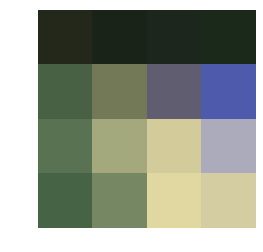

Data shape:  (4, 4, 3)


array([[[[0.14117648, 0.15686275, 0.10196079],
         [0.10196079, 0.13725491, 0.09019608],
         [0.10980392, 0.14901961, 0.10980392],
         [0.10588235, 0.16078432, 0.10588235]],

        [[0.28235295, 0.3764706 , 0.26666668],
         [0.4509804 , 0.4745098 , 0.34117648],
         [0.3764706 , 0.3647059 , 0.44313726],
         [0.30588236, 0.3529412 , 0.6745098 ]],

        [[0.34901962, 0.44705883, 0.32156864],
         [0.6431373 , 0.65882355, 0.49019608],
         [0.83137256, 0.79607844, 0.60784316],
         [0.67058825, 0.67058825, 0.73333335]],

        [[0.27450982, 0.3882353 , 0.27450982],
         [0.4627451 , 0.5294118 , 0.39215687],
         [0.8784314 , 0.84313726, 0.6313726 ],
         [0.83137256, 0.8039216 , 0.63529414]]]], dtype=float32)

In [62]:
load_data()

In [137]:
class SkipConnection(keras.layers.Layer):
    def call(self, inputs):
        layer_preprocess, layer_output = inputs
        skip_layer = layer_preprocess + layer_output
        return keras.layers.Activation("relu")(skip_layer)

In [138]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [139]:
K = keras.backend

codings_size = 500

encoder_inputs = keras.layers.Input(shape=(64, 64, 3))
z = keras.layers.Conv2D(16, kernel_size=3, strides=1, padding="same")(encoder_inputs)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Activation("relu")(z)

input_preprocessing_layer = keras.layers.Conv2D(32, kernel_size=3, strides=2, padding="same")(z)
z = keras.layers.BatchNormalization()(input_preprocessing_layer)
z = keras.layers.Activation("relu")(z)

z = keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Activation("relu")(z)

z = keras.layers.Flatten()(z)

codings_mean = keras.layers.Dense(codings_size, activation="relu")(z)
codings_log_var = keras.layers.Dense(codings_size, activation="relu")(z)
codings = Sampling()([codings_mean, codings_log_var])

encoder = keras.Model(inputs=[encoder_inputs], outputs=[input_preprocessing_layer, codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=(codings_size,))
preprocessing = keras.layers.Input(shape=(32, 32, 32))

x = keras.layers.Dense(16 * 16 * 64, activation="relu")(decoder_inputs)
x = keras.layers.Reshape((16, 16, 64))(x)

x = keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = SkipConnection()([preprocessing, x])

x = keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

decoder_outputs = keras.layers.Conv2DTranspose(3, kernel_size=3, strides=1, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs=[decoder_inputs, preprocessing], outputs=[decoder_outputs])

encoder_processing, _, _, codings = encoder(encoder_inputs)
reconstructions = decoder([codings, encoder_processing])

autoencoder = keras.Model(inputs=[encoder_inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
autoencoder.add_loss(K.mean(latent_loss) / (64 * 64 * 3))

Epoch:  1


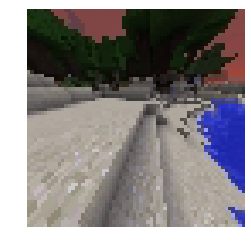

Data shape:  (64, 64, 3)
Epoch:  2


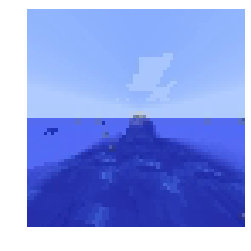

Data shape:  (64, 64, 3)
Epoch:  3


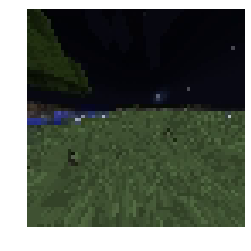

Data shape:  (64, 64, 3)
Epoch:  4


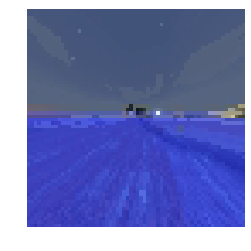

Data shape:  (64, 64, 3)
Epoch:  5


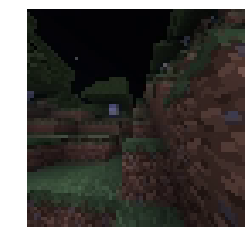

Data shape:  (64, 64, 3)
Epoch:  6


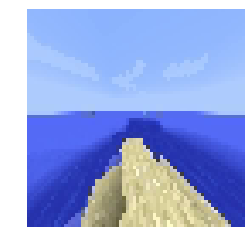

Data shape:  (64, 64, 3)
Epoch:  7


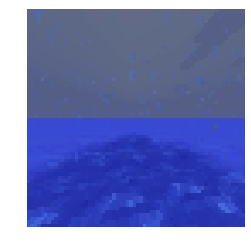

Data shape:  (64, 64, 3)
Epoch:  8


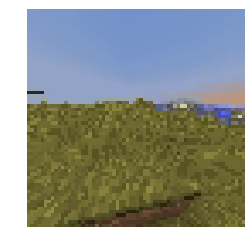

Data shape:  (64, 64, 3)
Epoch:  9


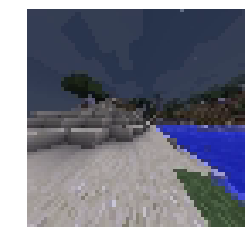

Data shape:  (64, 64, 3)
Epoch:  10


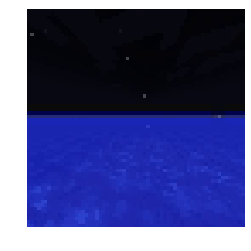

Data shape:  (64, 64, 3)
Epoch:  11


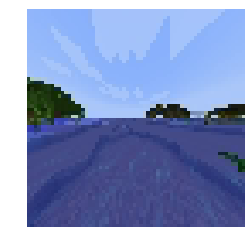

Data shape:  (64, 64, 3)


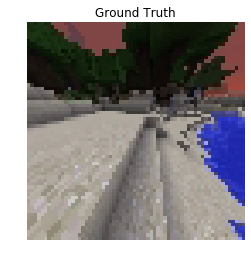

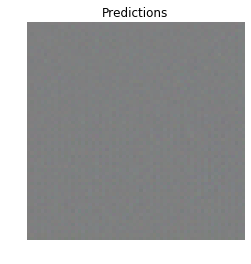

Loss:  tf.Tensor(0.69249964, shape=(), dtype=float32)
Epoch:  12


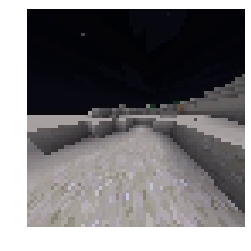

Data shape:  (64, 64, 3)


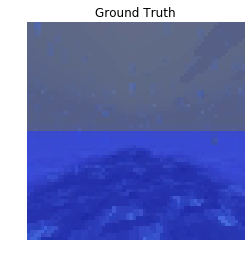

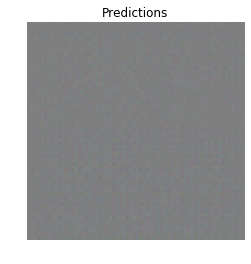

Loss:  tf.Tensor(0.69206125, shape=(), dtype=float32)
Epoch:  13


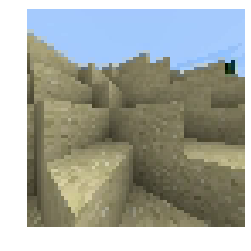

Data shape:  (64, 64, 3)


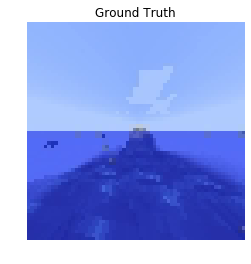

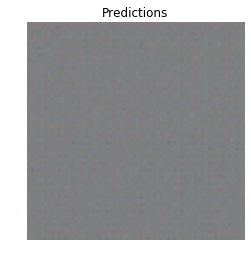

Loss:  tf.Tensor(0.691905, shape=(), dtype=float32)
Epoch:  14


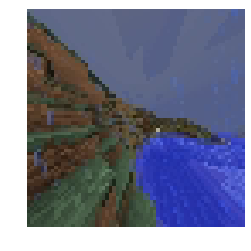

Data shape:  (64, 64, 3)


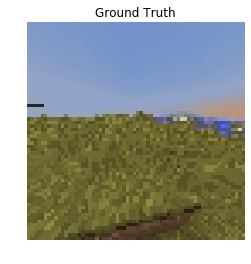

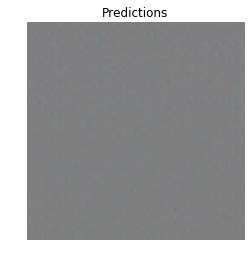

Loss:  tf.Tensor(0.6923394, shape=(), dtype=float32)
Epoch:  15


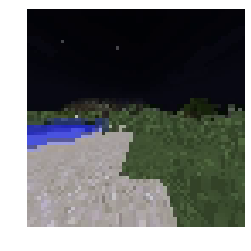

Data shape:  (64, 64, 3)


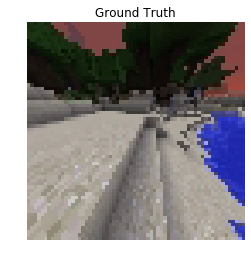

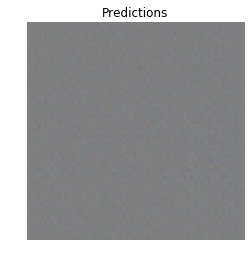

Loss:  tf.Tensor(0.692185, shape=(), dtype=float32)
Epoch:  16


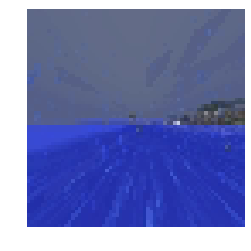

Data shape:  (64, 64, 3)


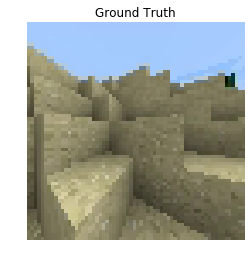

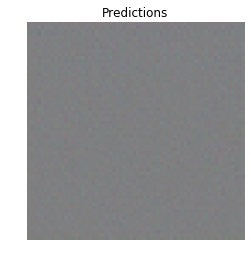

Loss:  tf.Tensor(0.6925174, shape=(), dtype=float32)
Epoch:  17


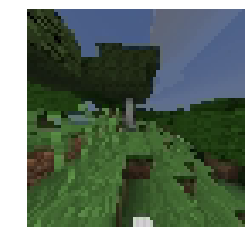

Data shape:  (64, 64, 3)


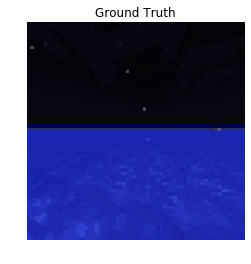

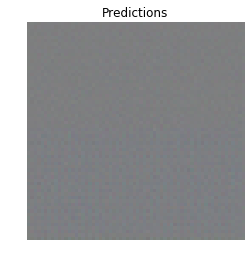

Loss:  tf.Tensor(0.69087195, shape=(), dtype=float32)
Epoch:  18


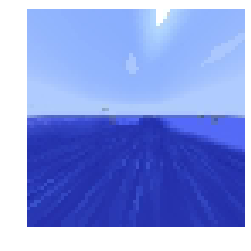

Data shape:  (64, 64, 3)


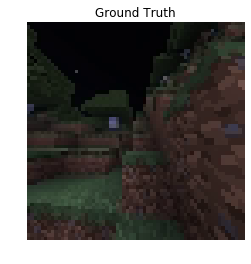

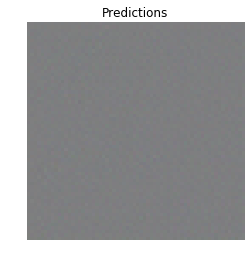

Loss:  tf.Tensor(0.6910379, shape=(), dtype=float32)
Epoch:  19


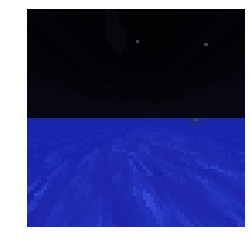

Data shape:  (64, 64, 3)


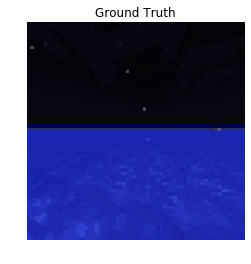

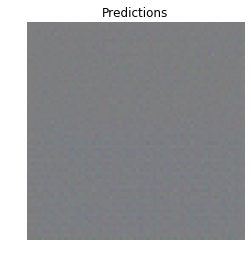

Loss:  tf.Tensor(0.6893396, shape=(), dtype=float32)
Epoch:  20


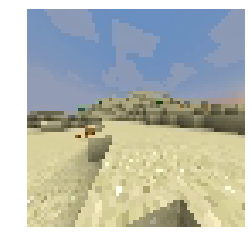

Data shape:  (64, 64, 3)


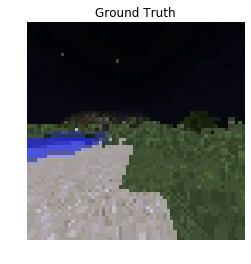

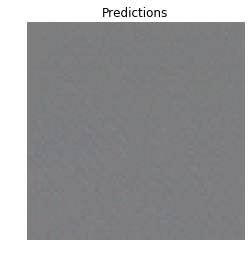

Loss:  tf.Tensor(0.6900253, shape=(), dtype=float32)
Epoch:  21


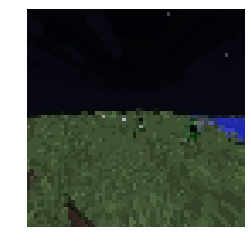

Data shape:  (64, 64, 3)


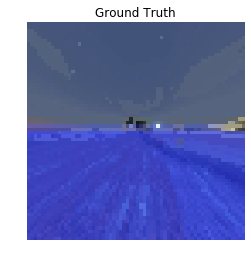

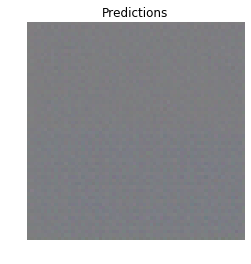

Loss:  tf.Tensor(0.68884414, shape=(), dtype=float32)
Epoch:  22


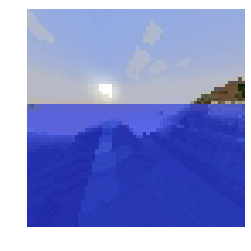

Data shape:  (64, 64, 3)


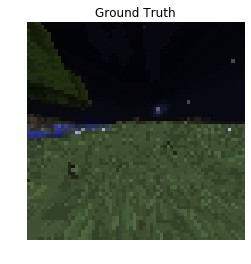

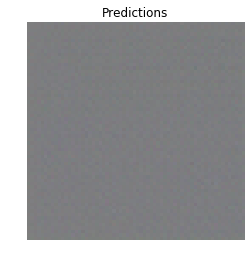

Loss:  tf.Tensor(0.6884686, shape=(), dtype=float32)
Epoch:  23


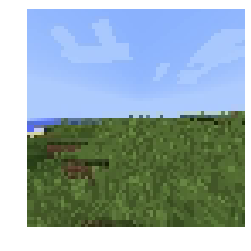

Data shape:  (64, 64, 3)


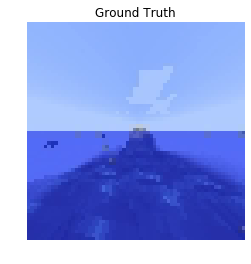

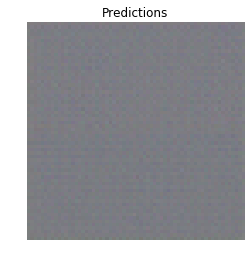

Loss:  tf.Tensor(0.68754363, shape=(), dtype=float32)
Epoch:  24


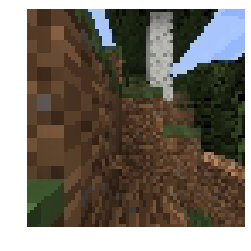

Data shape:  (64, 64, 3)


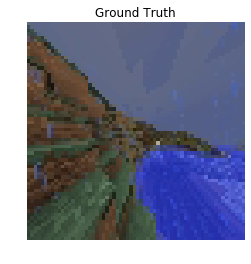

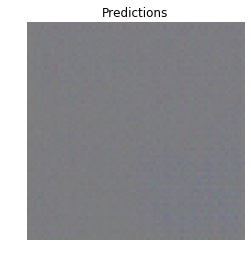

Loss:  tf.Tensor(0.6880777, shape=(), dtype=float32)
Epoch:  25


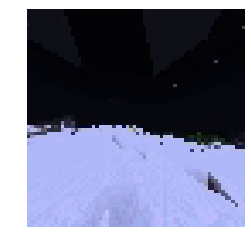

Data shape:  (64, 64, 3)


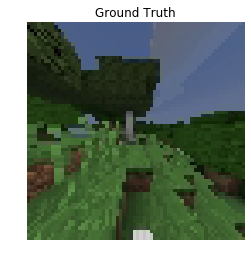

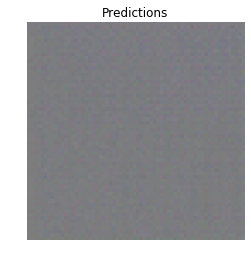

Loss:  tf.Tensor(0.6877564, shape=(), dtype=float32)
Epoch:  26


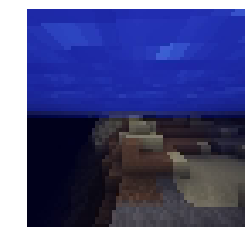

Data shape:  (64, 64, 3)


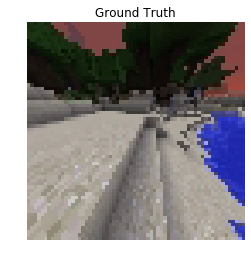

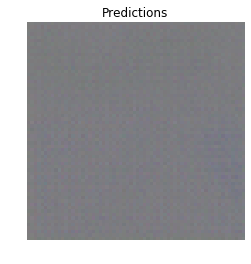

Loss:  tf.Tensor(0.68654656, shape=(), dtype=float32)
Epoch:  27


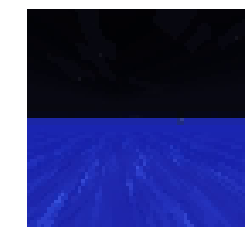

Data shape:  (64, 64, 3)


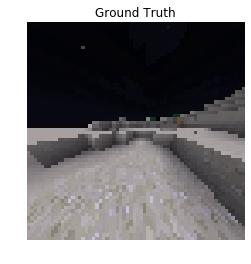

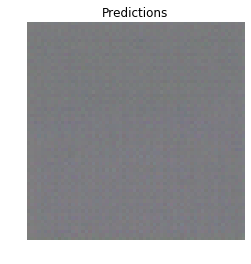

Loss:  tf.Tensor(0.68511486, shape=(), dtype=float32)
Epoch:  28


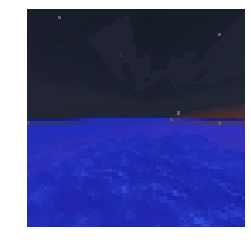

Data shape:  (64, 64, 3)


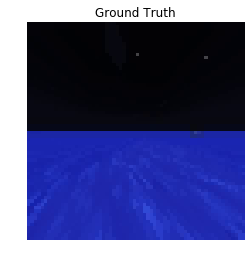

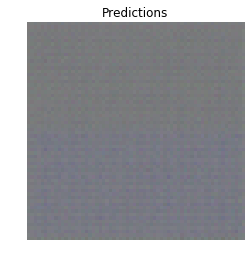

Loss:  tf.Tensor(0.6821513, shape=(), dtype=float32)
Epoch:  29


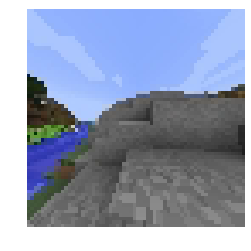

Data shape:  (64, 64, 3)


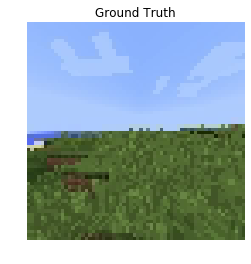

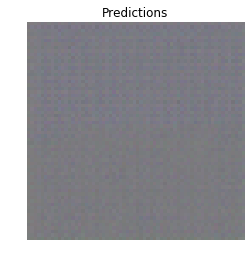

Loss:  tf.Tensor(0.68447644, shape=(), dtype=float32)
Epoch:  30


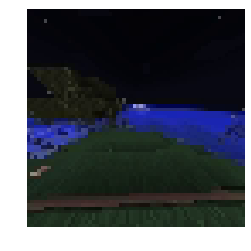

Data shape:  (64, 64, 3)


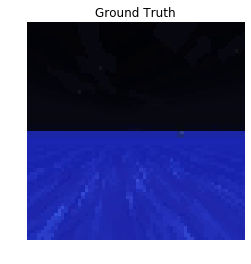

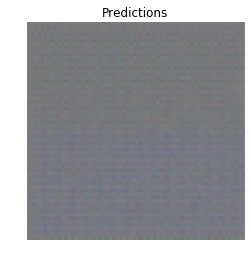

Loss:  tf.Tensor(0.6802269, shape=(), dtype=float32)
Epoch:  31


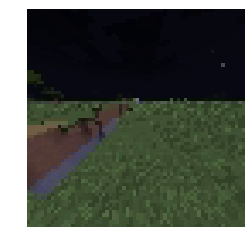

Data shape:  (64, 64, 3)


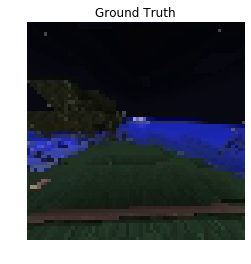

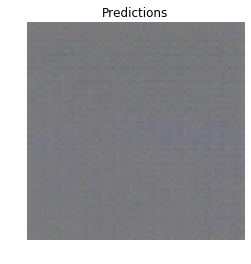

Loss:  tf.Tensor(0.67861265, shape=(), dtype=float32)
Epoch:  32


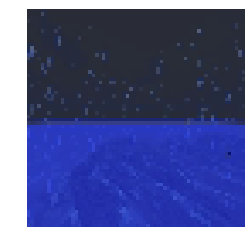

Data shape:  (64, 64, 3)


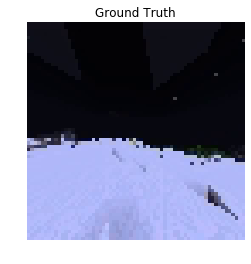

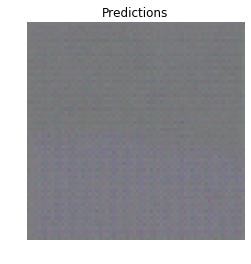

Loss:  tf.Tensor(0.67980224, shape=(), dtype=float32)
Epoch:  33


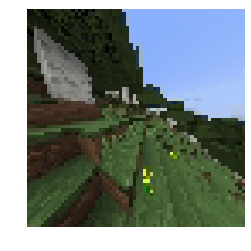

Data shape:  (64, 64, 3)


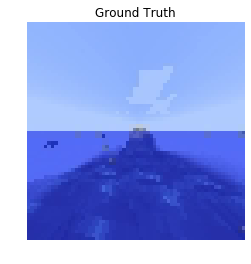

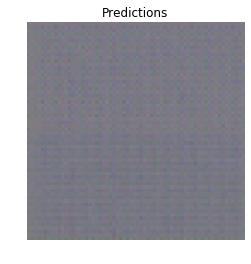

Loss:  tf.Tensor(0.68278176, shape=(), dtype=float32)
Epoch:  34


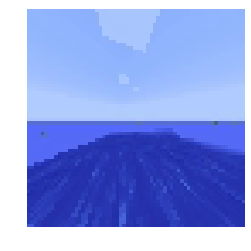

Data shape:  (64, 64, 3)


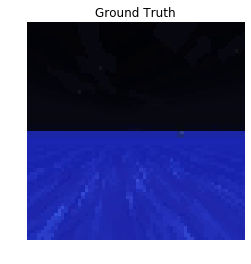

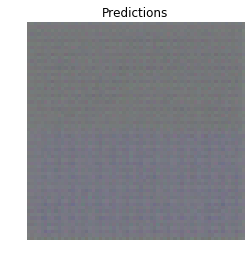

Loss:  tf.Tensor(0.6758171, shape=(), dtype=float32)
Epoch:  35


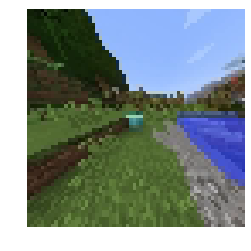

Data shape:  (64, 64, 3)


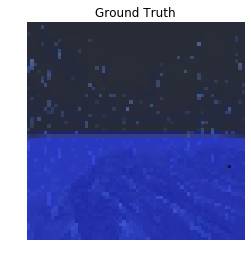

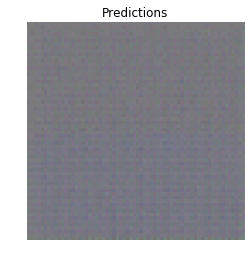

Loss:  tf.Tensor(0.67873615, shape=(), dtype=float32)
Epoch:  36


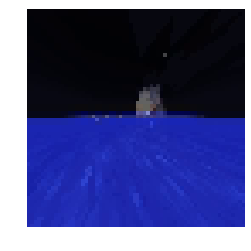

Data shape:  (64, 64, 3)


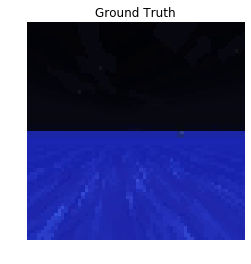

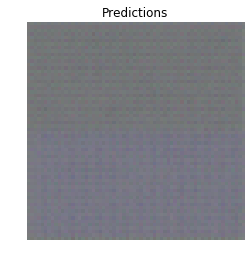

Loss:  tf.Tensor(0.674031, shape=(), dtype=float32)
Epoch:  37


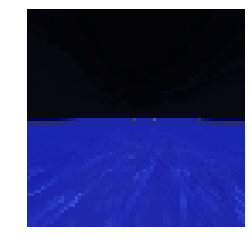

Data shape:  (64, 64, 3)


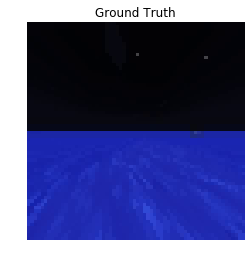

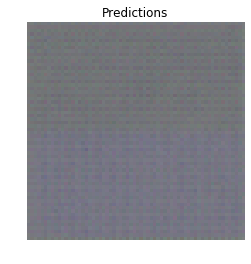

Loss:  tf.Tensor(0.674129, shape=(), dtype=float32)
Epoch:  38


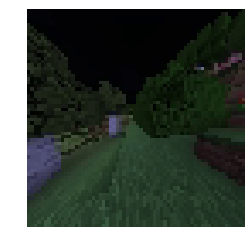

Data shape:  (64, 64, 3)


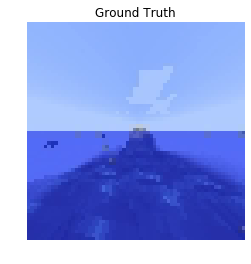

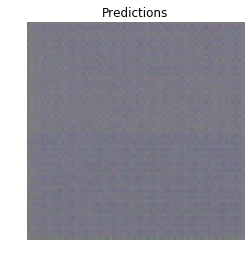

Loss:  tf.Tensor(0.6803512, shape=(), dtype=float32)
Epoch:  39


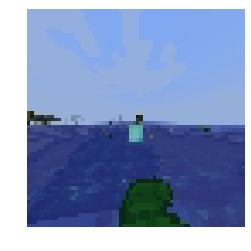

Data shape:  (64, 64, 3)


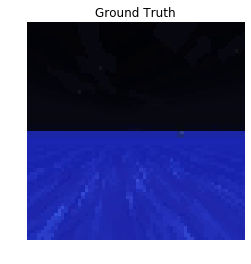

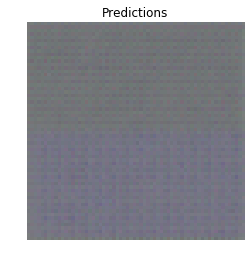

Loss:  tf.Tensor(0.66472924, shape=(), dtype=float32)
Epoch:  40


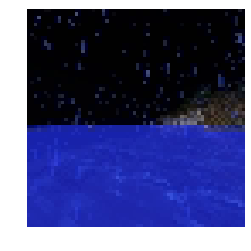

Data shape:  (64, 64, 3)


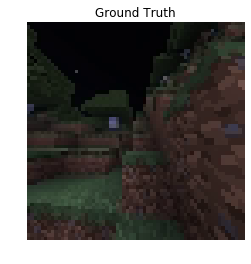

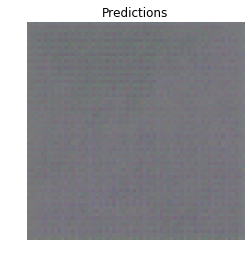

Loss:  tf.Tensor(0.6751082, shape=(), dtype=float32)
Epoch:  41


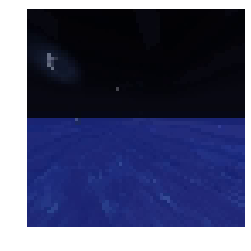

Data shape:  (64, 64, 3)


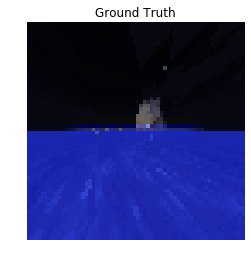

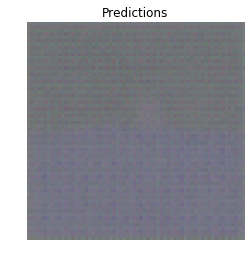

Loss:  tf.Tensor(0.66675436, shape=(), dtype=float32)
Epoch:  42


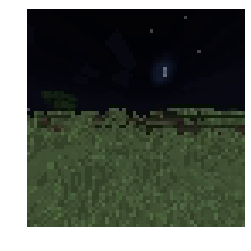

Data shape:  (64, 64, 3)


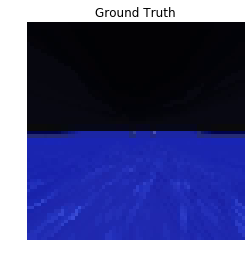

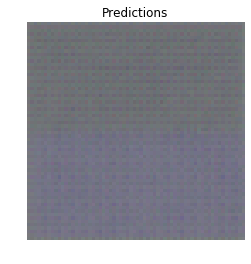

Loss:  tf.Tensor(0.66278535, shape=(), dtype=float32)
Epoch:  43


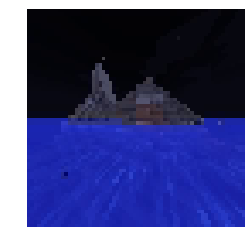

Data shape:  (64, 64, 3)


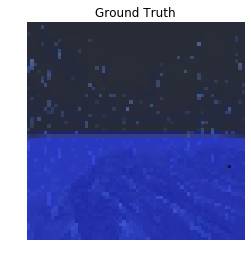

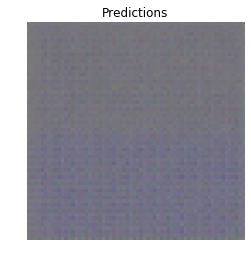

Loss:  tf.Tensor(0.6668444, shape=(), dtype=float32)
Epoch:  44


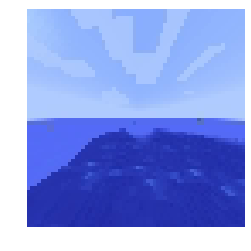

Data shape:  (64, 64, 3)


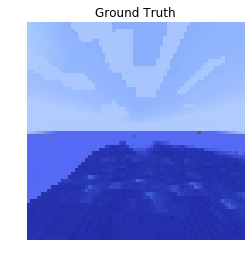

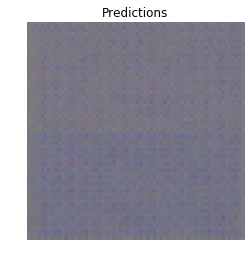

Loss:  tf.Tensor(0.6740441, shape=(), dtype=float32)
Epoch:  45


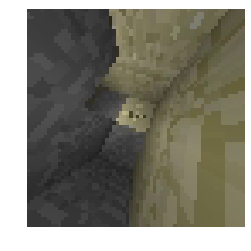

Data shape:  (64, 64, 3)


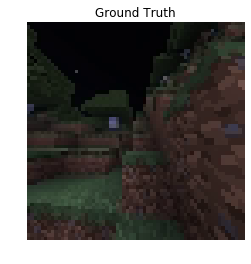

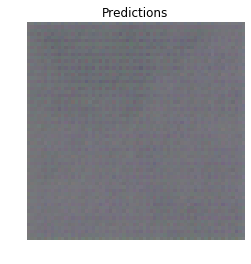

Loss:  tf.Tensor(0.66512465, shape=(), dtype=float32)
Epoch:  46


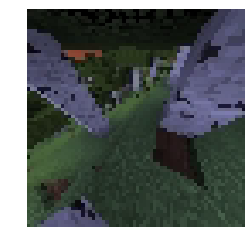

Data shape:  (64, 64, 3)


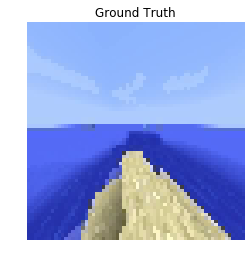

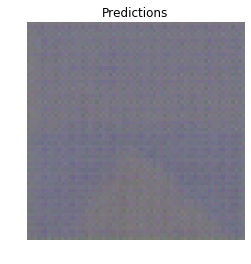

Loss:  tf.Tensor(0.67411876, shape=(), dtype=float32)
Epoch:  47


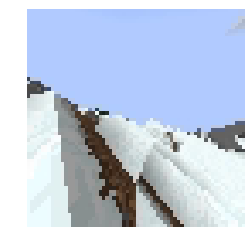

Data shape:  (64, 64, 3)


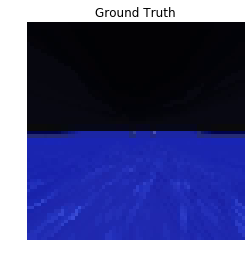

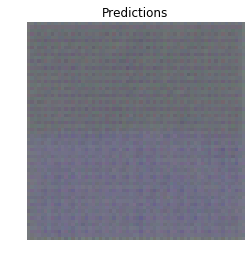

Loss:  tf.Tensor(0.6586724, shape=(), dtype=float32)
Epoch:  48


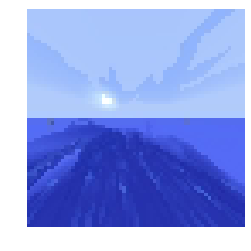

Data shape:  (64, 64, 3)


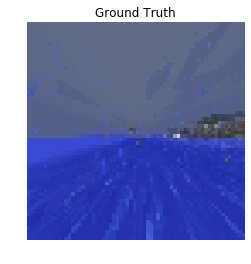

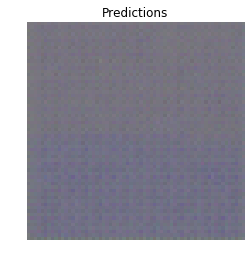

Loss:  tf.Tensor(0.6708227, shape=(), dtype=float32)
Epoch:  49


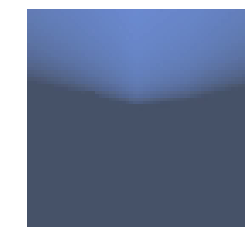

Data shape:  (64, 64, 3)


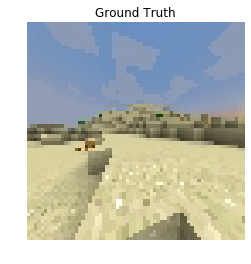

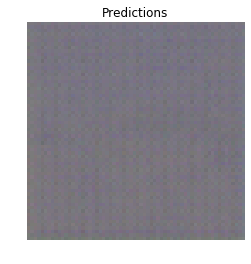

Loss:  tf.Tensor(0.6757623, shape=(), dtype=float32)
Epoch:  50


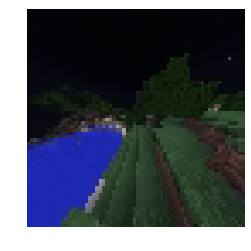

Data shape:  (64, 64, 3)


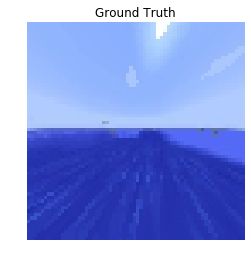

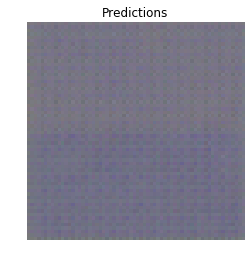

Loss:  tf.Tensor(0.6706265, shape=(), dtype=float32)
Epoch:  51


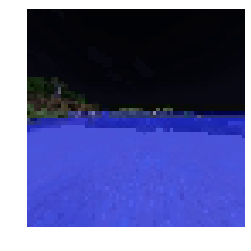

Data shape:  (64, 64, 3)


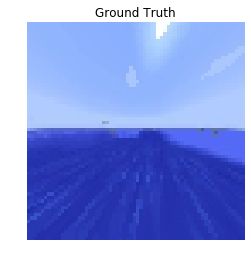

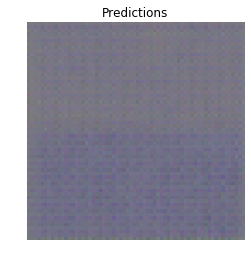

Loss:  tf.Tensor(0.6700371, shape=(), dtype=float32)
Epoch:  52


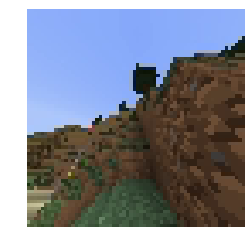

Data shape:  (64, 64, 3)


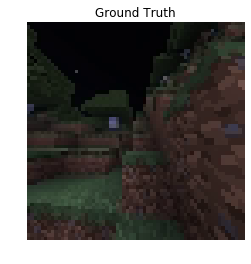

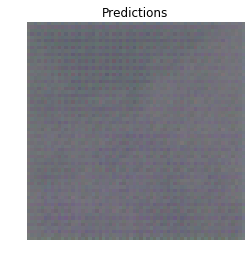

Loss:  tf.Tensor(0.66467816, shape=(), dtype=float32)
Epoch:  53


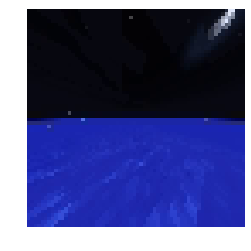

Data shape:  (64, 64, 3)


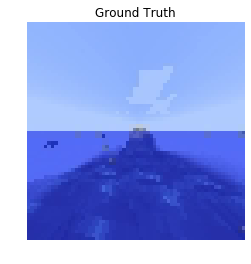

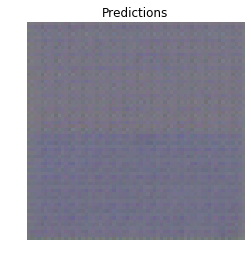

Loss:  tf.Tensor(0.6741538, shape=(), dtype=float32)
Epoch:  54


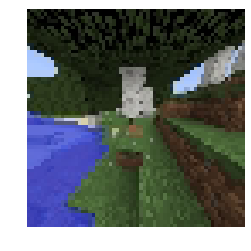

Data shape:  (64, 64, 3)


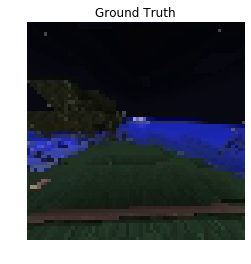

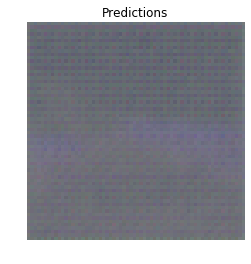

Loss:  tf.Tensor(0.6532911, shape=(), dtype=float32)
Epoch:  55


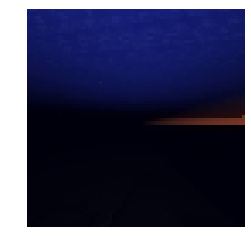

Data shape:  (64, 64, 3)


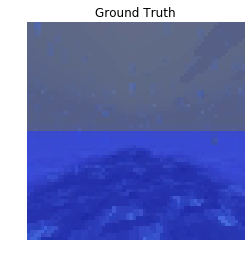

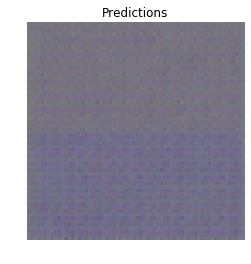

Loss:  tf.Tensor(0.66522086, shape=(), dtype=float32)
Epoch:  56


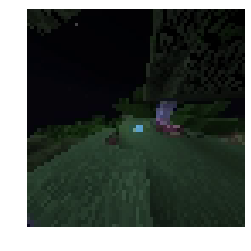

Data shape:  (64, 64, 3)


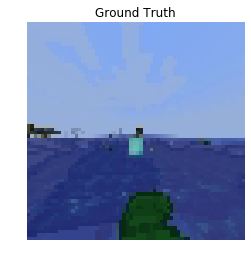

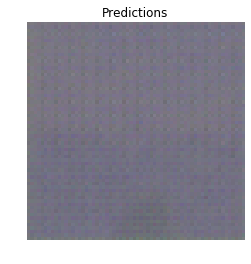

Loss:  tf.Tensor(0.672914, shape=(), dtype=float32)
Epoch:  57


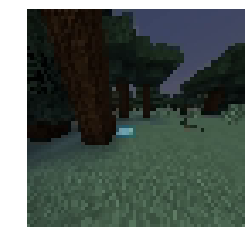

Data shape:  (64, 64, 3)


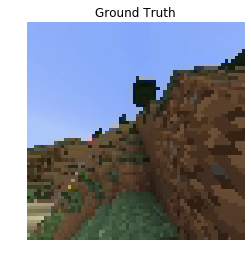

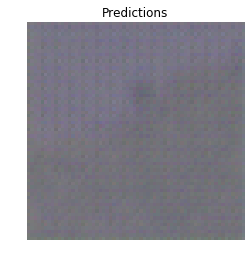

Loss:  tf.Tensor(0.6695676, shape=(), dtype=float32)
Epoch:  58


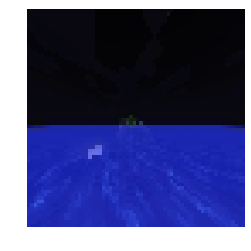

Data shape:  (64, 64, 3)


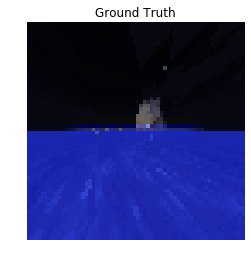

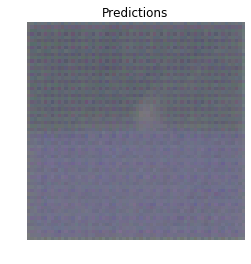

Loss:  tf.Tensor(0.6541414, shape=(), dtype=float32)
Epoch:  59


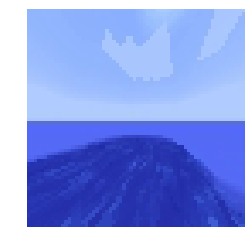

Data shape:  (64, 64, 3)


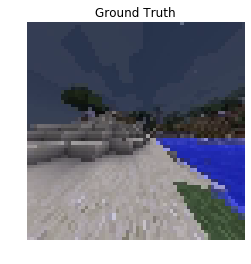

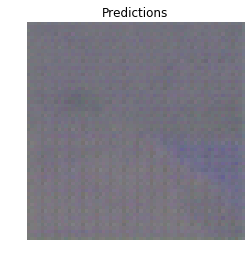

Loss:  tf.Tensor(0.6704682, shape=(), dtype=float32)
Epoch:  60


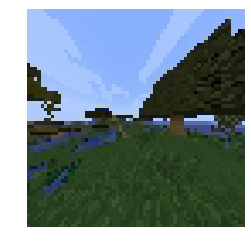

Data shape:  (64, 64, 3)


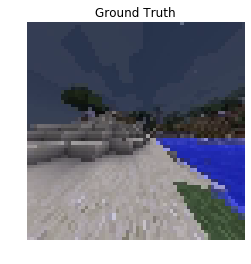

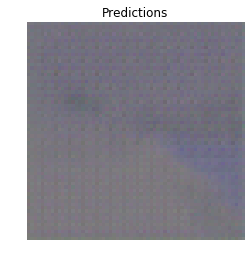

Loss:  tf.Tensor(0.6709819, shape=(), dtype=float32)
Epoch:  61


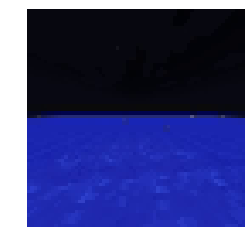

Data shape:  (64, 64, 3)


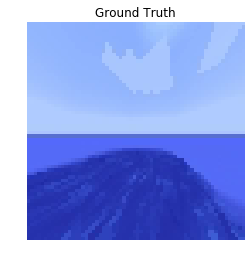

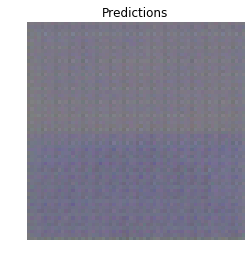

Loss:  tf.Tensor(0.6750975, shape=(), dtype=float32)
Epoch:  62


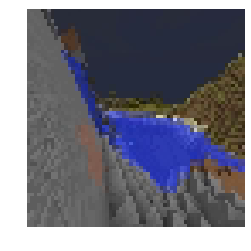

Data shape:  (64, 64, 3)


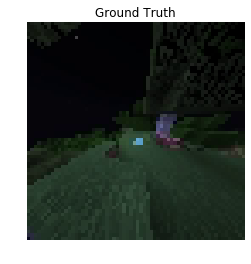

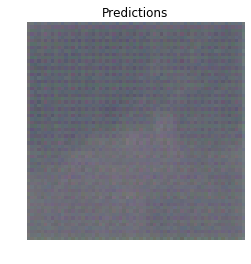

Loss:  tf.Tensor(0.642797, shape=(), dtype=float32)
Epoch:  63


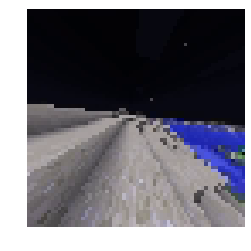

Data shape:  (64, 64, 3)


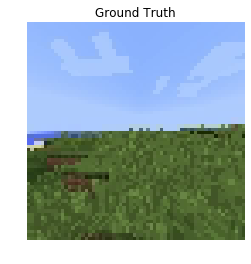

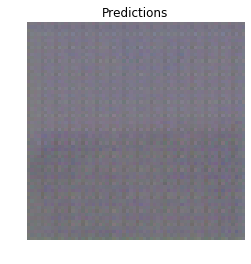

Loss:  tf.Tensor(0.6771689, shape=(), dtype=float32)
Epoch:  64


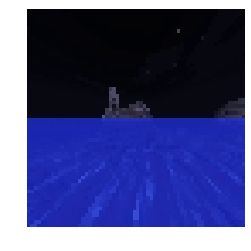

Data shape:  (64, 64, 3)


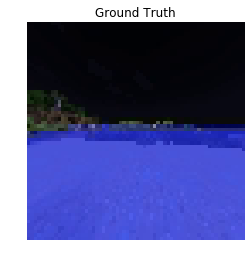

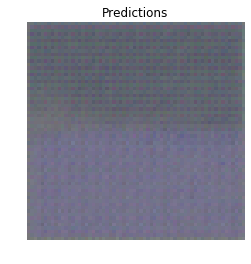

Loss:  tf.Tensor(0.65163517, shape=(), dtype=float32)
Epoch:  65


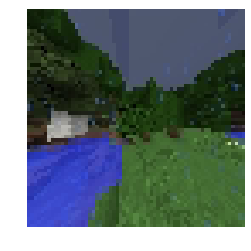

Data shape:  (64, 64, 3)


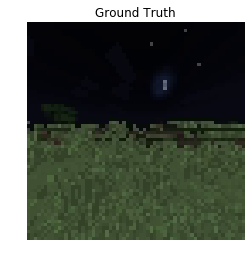

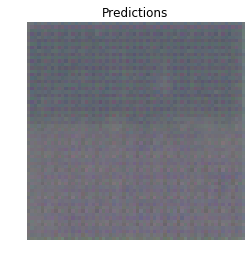

Loss:  tf.Tensor(0.6498623, shape=(), dtype=float32)
Epoch:  66


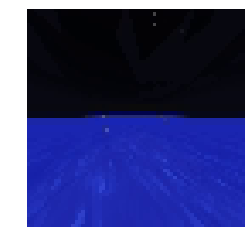

Data shape:  (64, 64, 3)


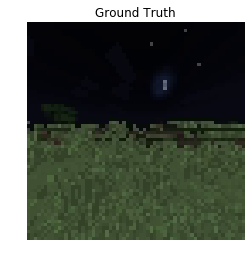

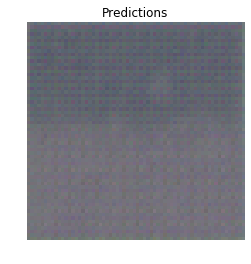

Loss:  tf.Tensor(0.65535223, shape=(), dtype=float32)
Epoch:  67


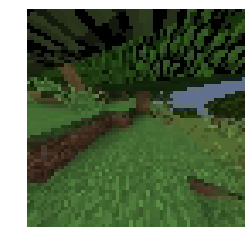

Data shape:  (64, 64, 3)


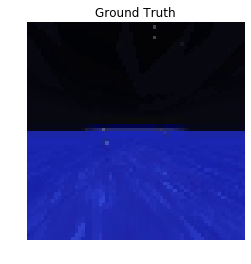

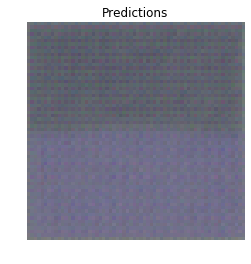

Loss:  tf.Tensor(0.6517172, shape=(), dtype=float32)
Epoch:  68


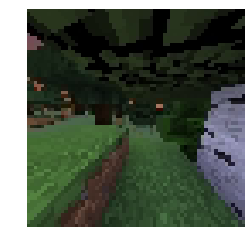

Data shape:  (64, 64, 3)


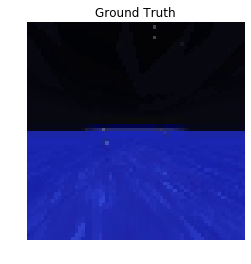

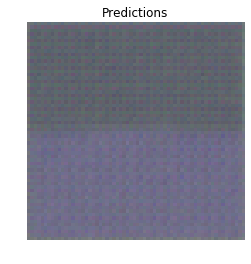

Loss:  tf.Tensor(0.6425239, shape=(), dtype=float32)
Epoch:  69


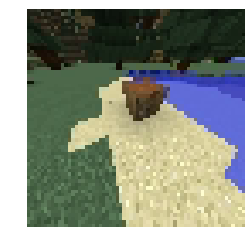

Data shape:  (64, 64, 3)


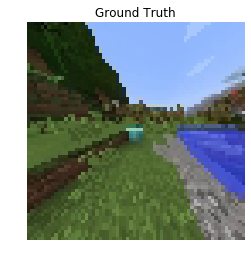

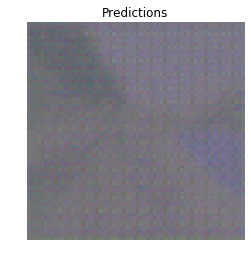

Loss:  tf.Tensor(0.667259, shape=(), dtype=float32)
Epoch:  70


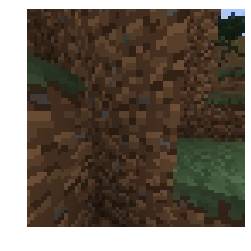

Data shape:  (64, 64, 3)


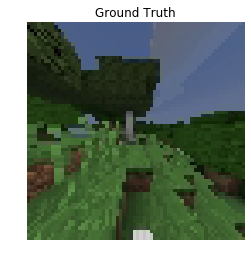

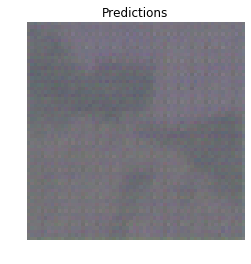

Loss:  tf.Tensor(0.656061, shape=(), dtype=float32)
Epoch:  71


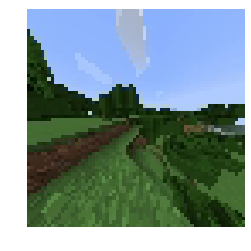

Data shape:  (64, 64, 3)


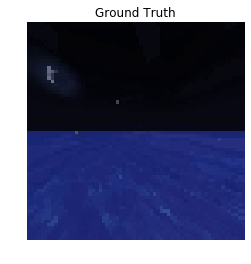

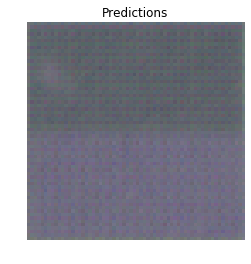

Loss:  tf.Tensor(0.63431185, shape=(), dtype=float32)
Epoch:  72


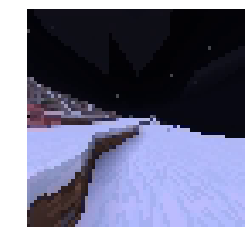

Data shape:  (64, 64, 3)


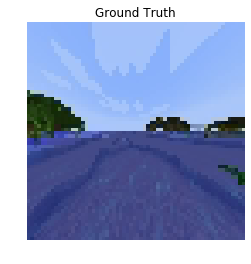

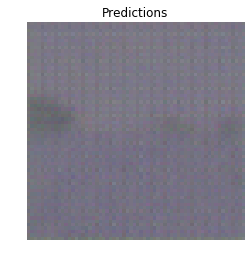

Loss:  tf.Tensor(0.6737666, shape=(), dtype=float32)
Epoch:  73


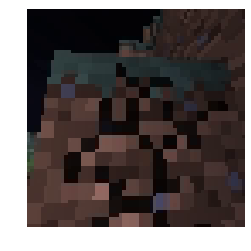

Data shape:  (64, 64, 3)


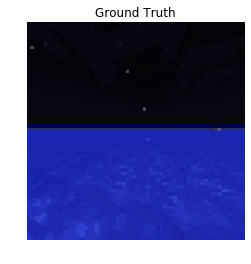

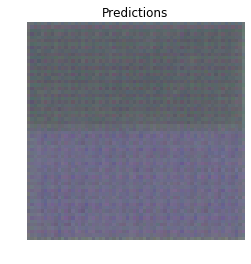

Loss:  tf.Tensor(0.65453255, shape=(), dtype=float32)
Epoch:  74


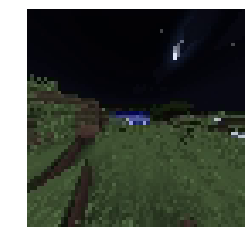

Data shape:  (64, 64, 3)


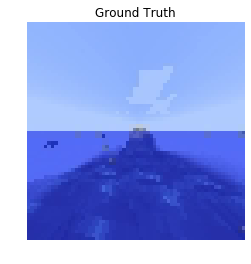

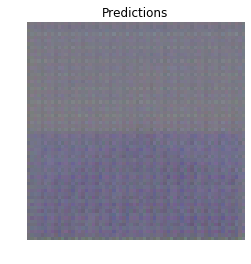

Loss:  tf.Tensor(0.67487925, shape=(), dtype=float32)
Epoch:  75


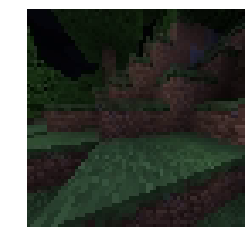

Data shape:  (64, 64, 3)


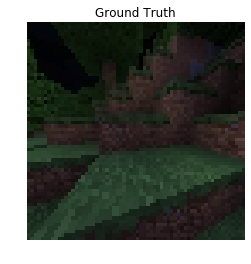

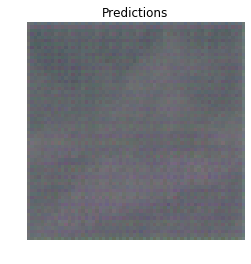

Loss:  tf.Tensor(0.63888943, shape=(), dtype=float32)
Epoch:  76


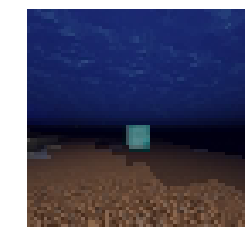

Data shape:  (64, 64, 3)


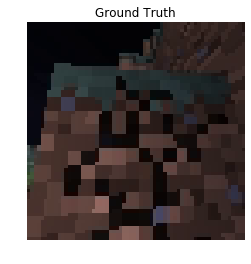

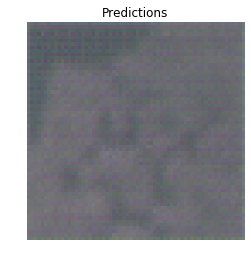

Loss:  tf.Tensor(0.6458628, shape=(), dtype=float32)
Epoch:  77


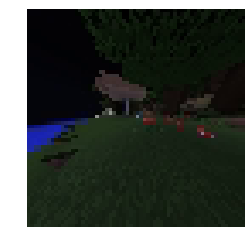

Data shape:  (64, 64, 3)


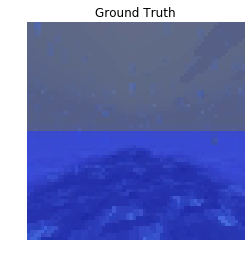

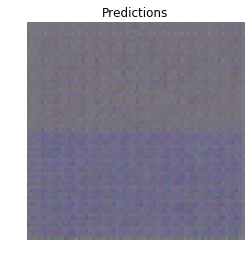

Loss:  tf.Tensor(0.66052926, shape=(), dtype=float32)
Epoch:  78


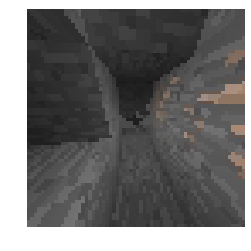

Data shape:  (64, 64, 3)


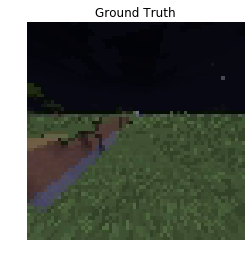

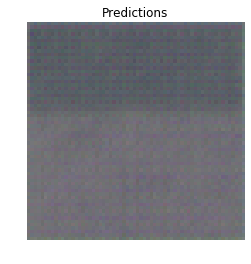

Loss:  tf.Tensor(0.6397823, shape=(), dtype=float32)
Epoch:  79


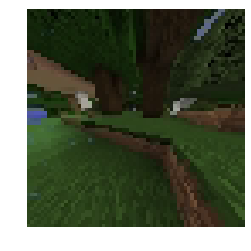

Data shape:  (64, 64, 3)


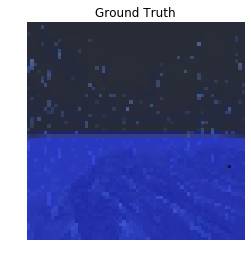

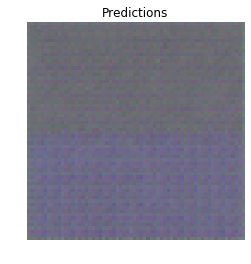

Loss:  tf.Tensor(0.6498498, shape=(), dtype=float32)
Epoch:  80


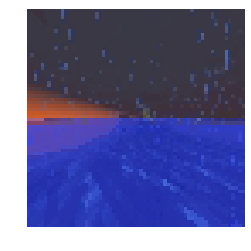

Data shape:  (64, 64, 3)


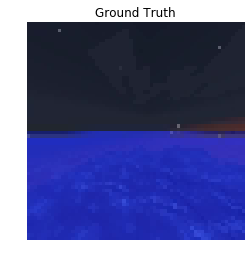

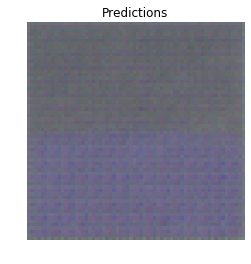

Loss:  tf.Tensor(0.64320624, shape=(), dtype=float32)
Epoch:  81


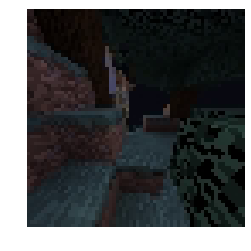

Data shape:  (64, 64, 3)


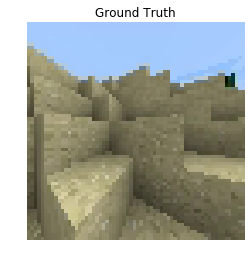

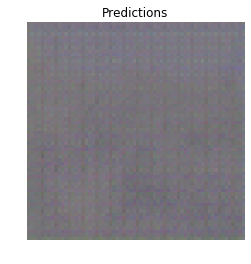

Loss:  tf.Tensor(0.6702697, shape=(), dtype=float32)
Epoch:  82


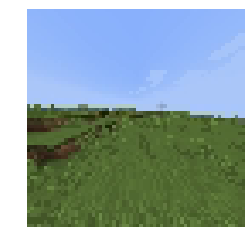

Data shape:  (64, 64, 3)


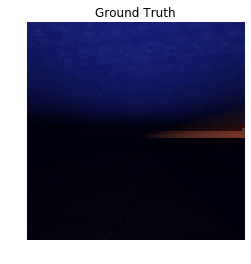

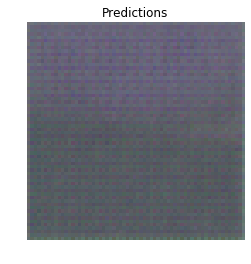

Loss:  tf.Tensor(0.6334133, shape=(), dtype=float32)
Epoch:  83


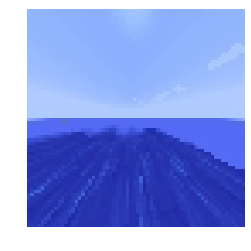

Data shape:  (64, 64, 3)


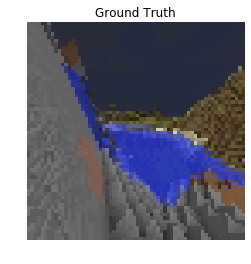

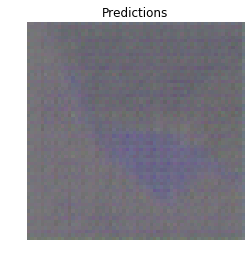

Loss:  tf.Tensor(0.65524805, shape=(), dtype=float32)
Epoch:  84


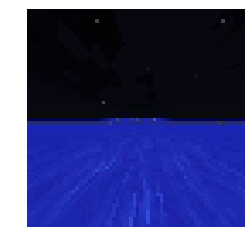

Data shape:  (64, 64, 3)


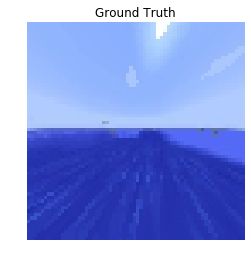

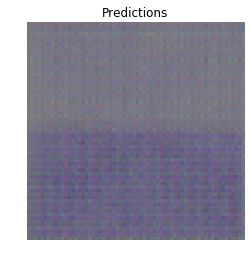

Loss:  tf.Tensor(0.6655557, shape=(), dtype=float32)
Epoch:  85


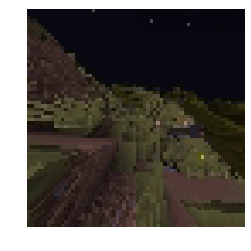

Data shape:  (64, 64, 3)


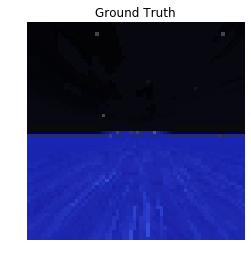

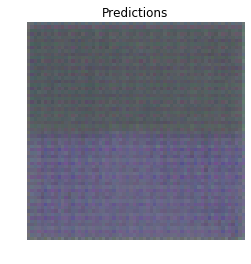

Loss:  tf.Tensor(0.6267319, shape=(), dtype=float32)
Epoch:  86


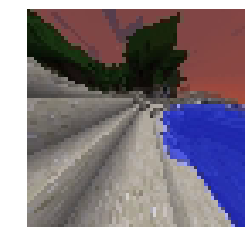

Data shape:  (64, 64, 3)


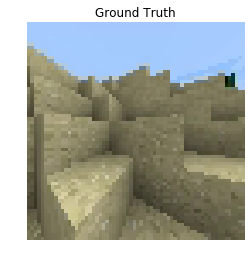

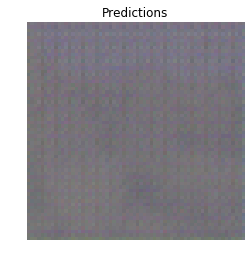

Loss:  tf.Tensor(0.6681082, shape=(), dtype=float32)
Epoch:  87


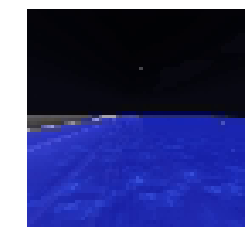

Data shape:  (64, 64, 3)


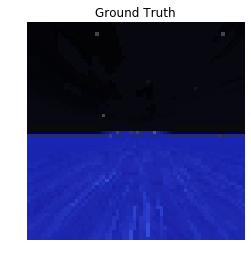

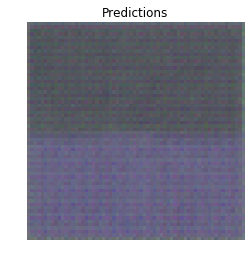

Loss:  tf.Tensor(0.6277082, shape=(), dtype=float32)
Epoch:  88


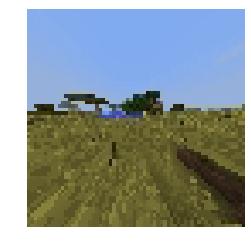

Data shape:  (64, 64, 3)


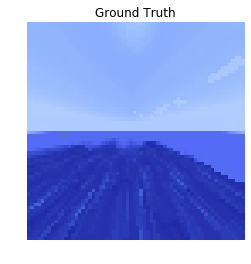

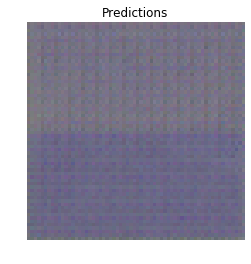

Loss:  tf.Tensor(0.6635267, shape=(), dtype=float32)
Epoch:  89


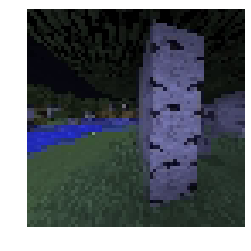

Data shape:  (64, 64, 3)


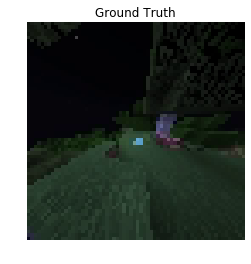

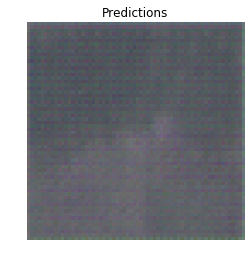

Loss:  tf.Tensor(0.61062896, shape=(), dtype=float32)
Epoch:  90


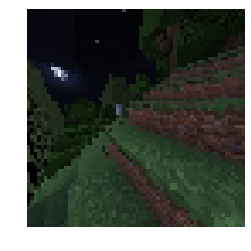

Data shape:  (64, 64, 3)


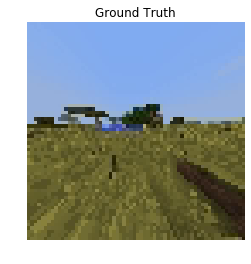

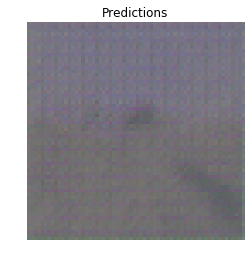

Loss:  tf.Tensor(0.6666677, shape=(), dtype=float32)
Epoch:  91


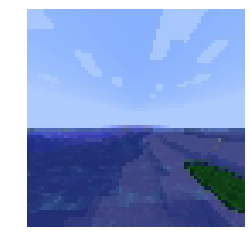

Data shape:  (64, 64, 3)


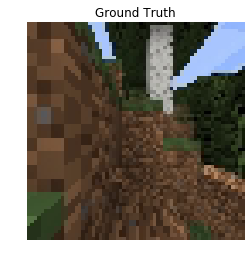

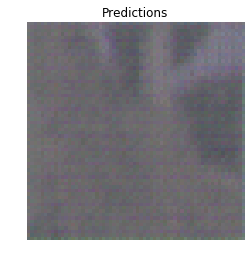

Loss:  tf.Tensor(0.6455226, shape=(), dtype=float32)
Epoch:  92


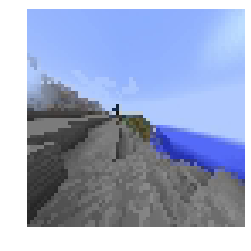

Data shape:  (64, 64, 3)


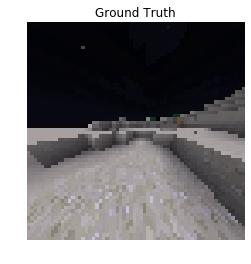

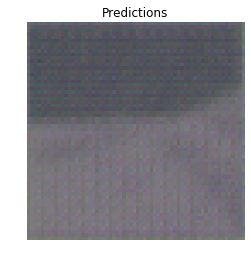

Loss:  tf.Tensor(0.6411631, shape=(), dtype=float32)
Epoch:  93


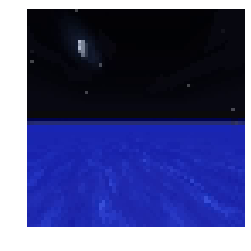

Data shape:  (64, 64, 3)


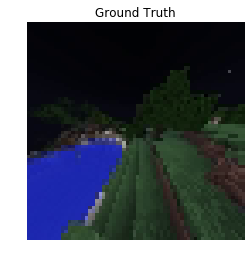

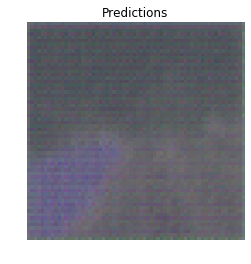

Loss:  tf.Tensor(0.6143141, shape=(), dtype=float32)
Epoch:  94


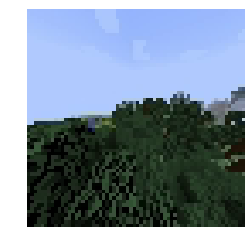

Data shape:  (64, 64, 3)


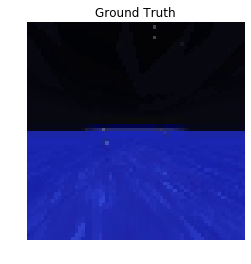

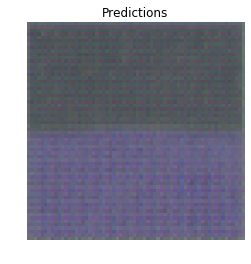

Loss:  tf.Tensor(0.633075, shape=(), dtype=float32)
Epoch:  95


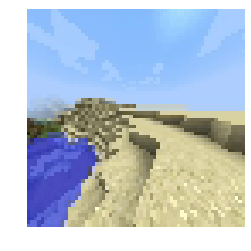

Data shape:  (64, 64, 3)


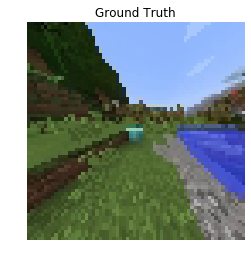

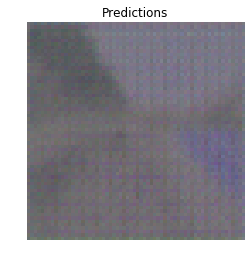

Loss:  tf.Tensor(0.65935767, shape=(), dtype=float32)
Epoch:  96


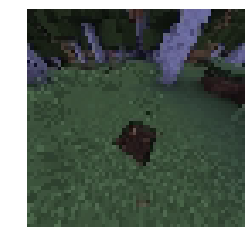

Data shape:  (64, 64, 3)


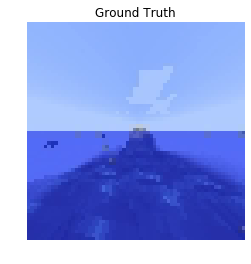

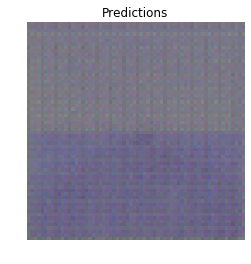

Loss:  tf.Tensor(0.67169976, shape=(), dtype=float32)
Epoch:  97


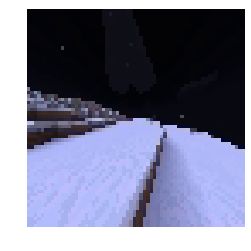

Data shape:  (64, 64, 3)


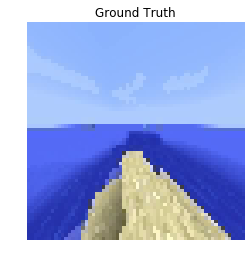

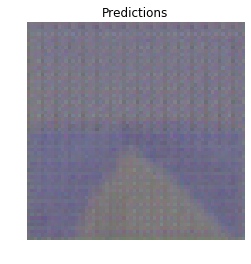

Loss:  tf.Tensor(0.6761737, shape=(), dtype=float32)
Epoch:  98


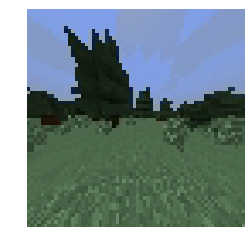

Data shape:  (64, 64, 3)


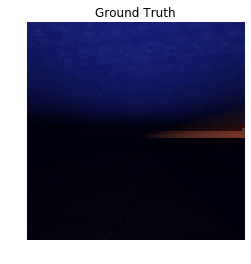

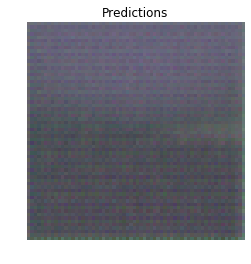

Loss:  tf.Tensor(0.62348676, shape=(), dtype=float32)
Epoch:  99


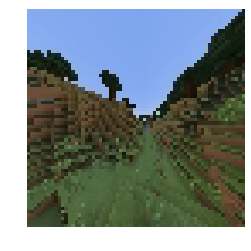

Data shape:  (64, 64, 3)


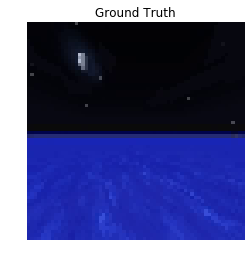

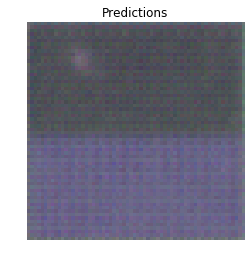

Loss:  tf.Tensor(0.63756514, shape=(), dtype=float32)
Epoch:  100


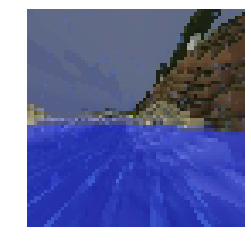

Data shape:  (64, 64, 3)


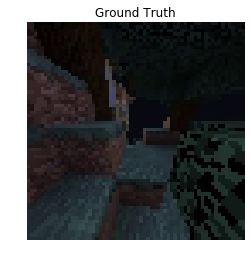

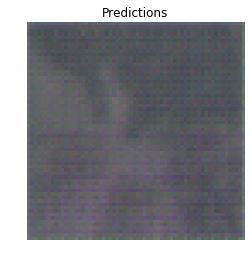

Loss:  tf.Tensor(0.64654887, shape=(), dtype=float32)
Epoch:  101


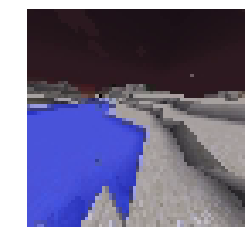

Data shape:  (64, 64, 3)


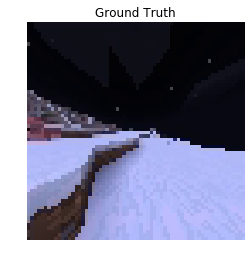

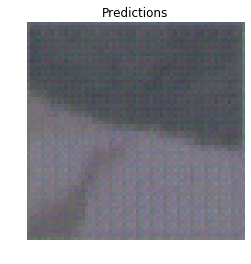

Loss:  tf.Tensor(0.6523414, shape=(), dtype=float32)
Epoch:  102


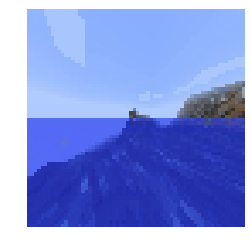

Data shape:  (64, 64, 3)


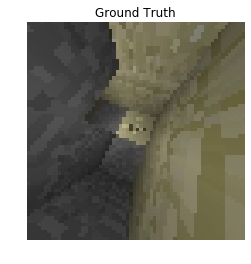

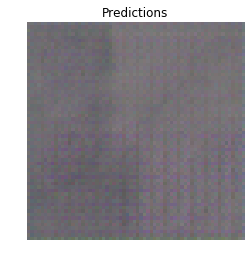

Loss:  tf.Tensor(0.66075575, shape=(), dtype=float32)
Epoch:  103


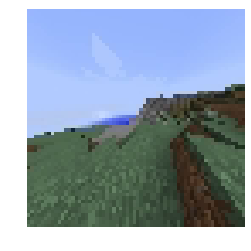

Data shape:  (64, 64, 3)


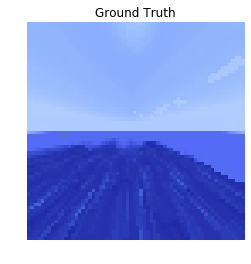

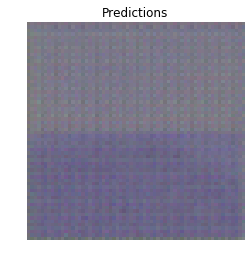

Loss:  tf.Tensor(0.6703438, shape=(), dtype=float32)
Epoch:  104


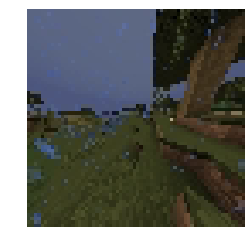

Data shape:  (64, 64, 3)


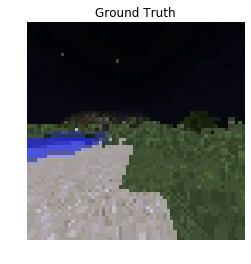

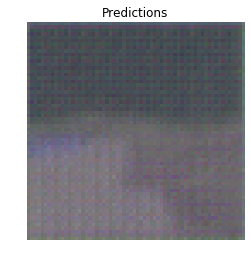

Loss:  tf.Tensor(0.639572, shape=(), dtype=float32)
Epoch:  105


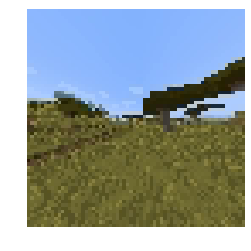

Data shape:  (64, 64, 3)


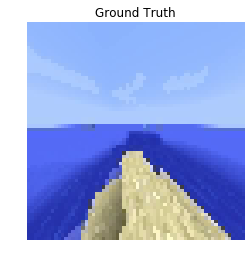

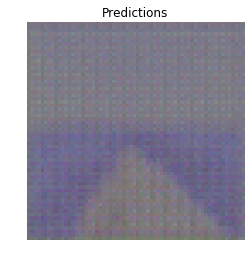

Loss:  tf.Tensor(0.6775335, shape=(), dtype=float32)
Epoch:  106


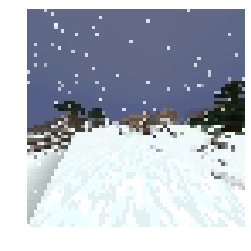

Data shape:  (64, 64, 3)


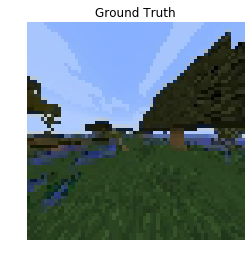

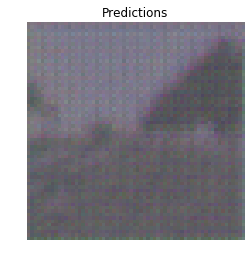

Loss:  tf.Tensor(0.6570066, shape=(), dtype=float32)
Epoch:  107


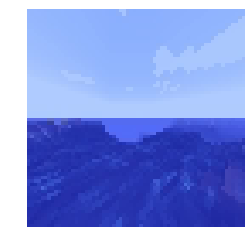

Data shape:  (64, 64, 3)


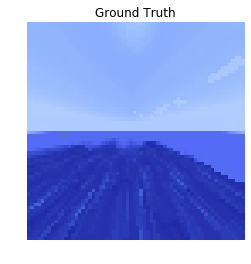

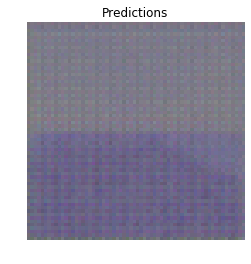

Loss:  tf.Tensor(0.6720897, shape=(), dtype=float32)
Epoch:  108


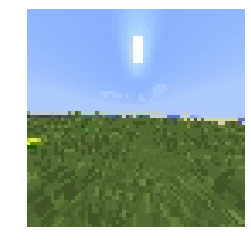

Data shape:  (64, 64, 3)


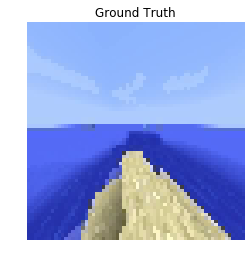

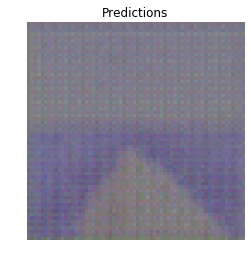

Loss:  tf.Tensor(0.6808574, shape=(), dtype=float32)
Epoch:  109


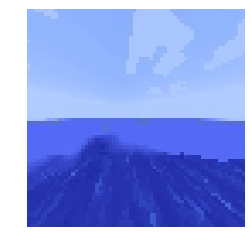

Data shape:  (64, 64, 3)


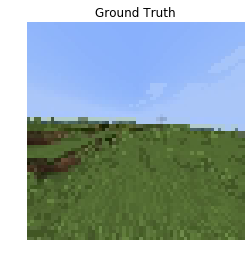

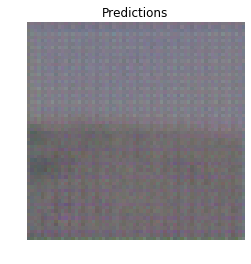

Loss:  tf.Tensor(0.67248356, shape=(), dtype=float32)
Epoch:  110


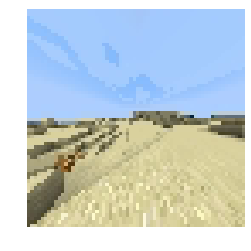

Data shape:  (64, 64, 3)


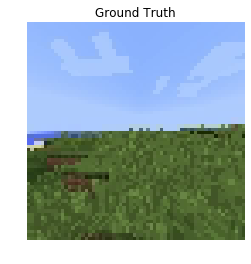

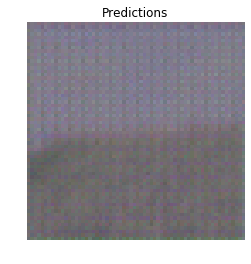

Loss:  tf.Tensor(0.6751681, shape=(), dtype=float32)
Epoch:  111


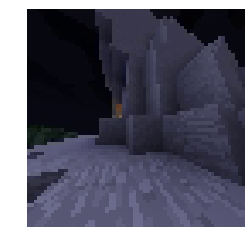

Data shape:  (64, 64, 3)


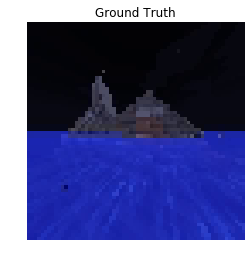

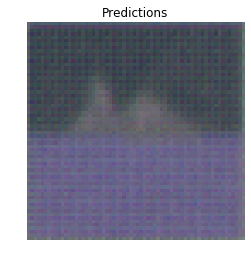

Loss:  tf.Tensor(0.6749785, shape=(), dtype=float32)
Epoch:  112


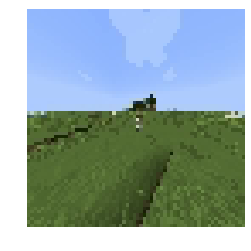

Data shape:  (64, 64, 3)


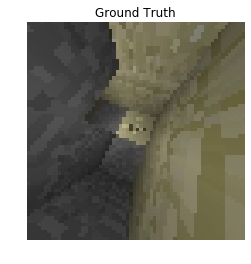

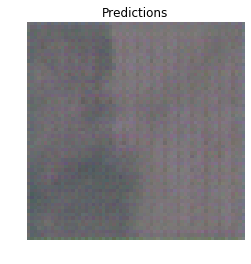

Loss:  tf.Tensor(0.66030943, shape=(), dtype=float32)
Epoch:  113


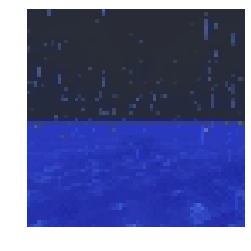

Data shape:  (64, 64, 3)


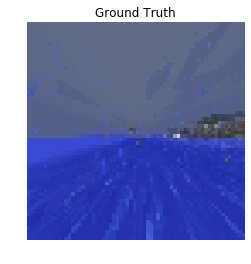

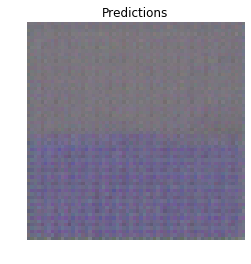

Loss:  tf.Tensor(0.6731199, shape=(), dtype=float32)
Epoch:  114


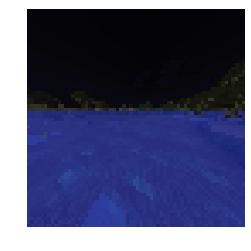

Data shape:  (64, 64, 3)


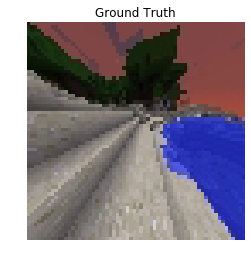

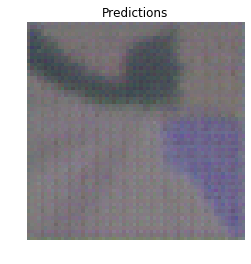

Loss:  tf.Tensor(0.6692801, shape=(), dtype=float32)
Epoch:  115


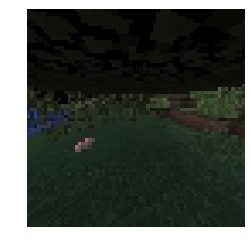

Data shape:  (64, 64, 3)


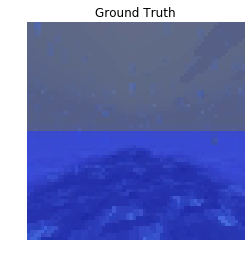

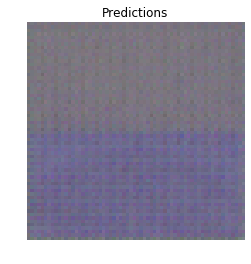

Loss:  tf.Tensor(0.6733018, shape=(), dtype=float32)
Epoch:  116


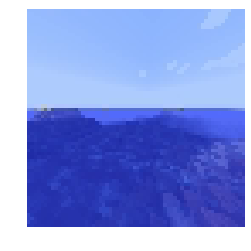

Data shape:  (64, 64, 3)


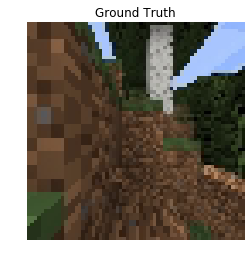

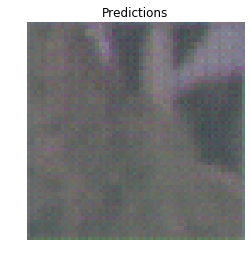

Loss:  tf.Tensor(0.65583146, shape=(), dtype=float32)
Epoch:  117


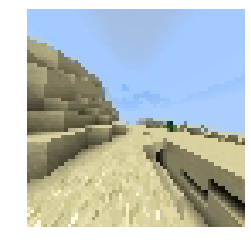

Data shape:  (64, 64, 3)


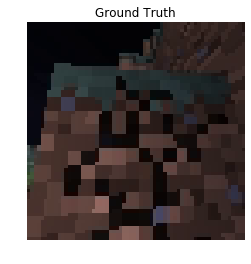

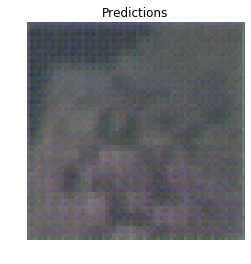

Loss:  tf.Tensor(0.6250292, shape=(), dtype=float32)
Epoch:  118


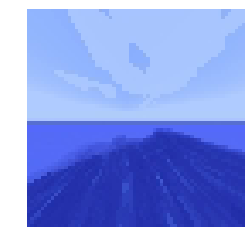

Data shape:  (64, 64, 3)


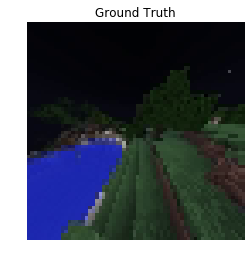

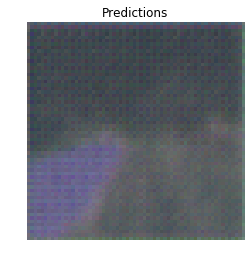

Loss:  tf.Tensor(0.634638, shape=(), dtype=float32)
Epoch:  119


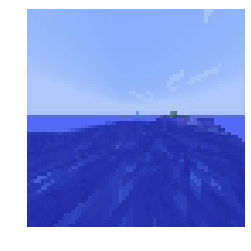

Data shape:  (64, 64, 3)


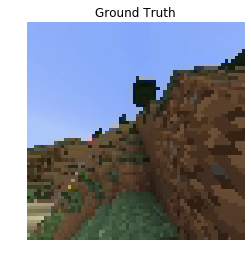

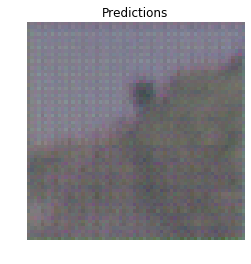

Loss:  tf.Tensor(0.66838074, shape=(), dtype=float32)
Epoch:  120


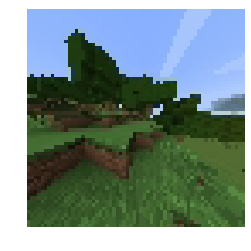

Data shape:  (64, 64, 3)


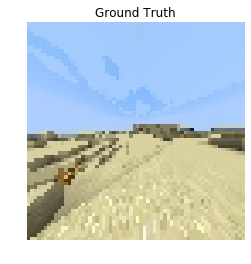

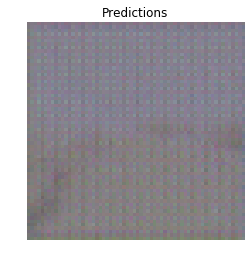

Loss:  tf.Tensor(0.7024678, shape=(), dtype=float32)
Epoch:  121


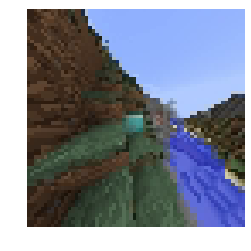

Data shape:  (64, 64, 3)


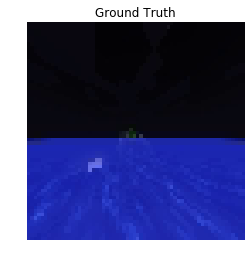

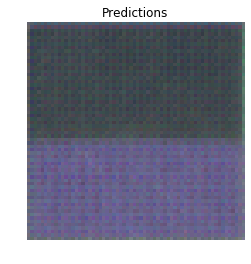

Loss:  tf.Tensor(0.6341175, shape=(), dtype=float32)
Epoch:  122


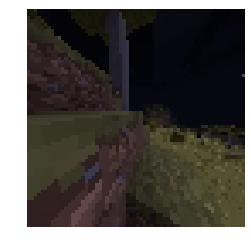

Data shape:  (64, 64, 3)


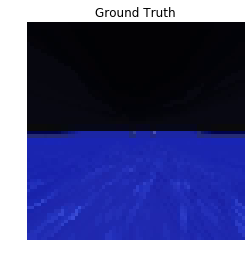

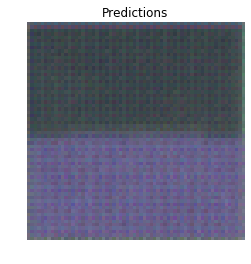

Loss:  tf.Tensor(0.653352, shape=(), dtype=float32)
Epoch:  123


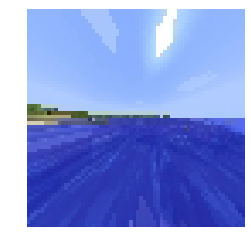

Data shape:  (64, 64, 3)


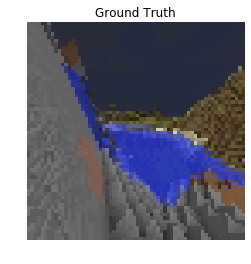

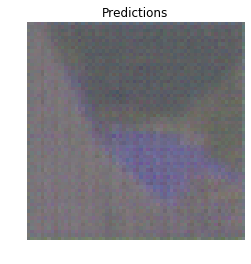

Loss:  tf.Tensor(0.65733755, shape=(), dtype=float32)
Epoch:  124


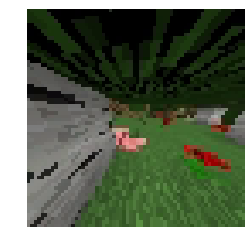

Data shape:  (64, 64, 3)


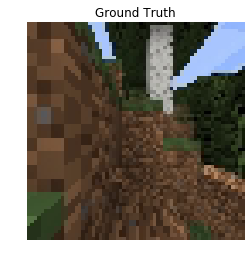

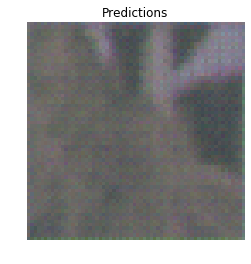

Loss:  tf.Tensor(0.6640235, shape=(), dtype=float32)
Epoch:  125


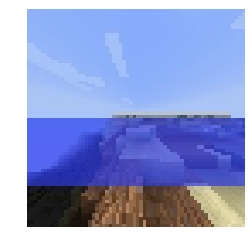

Data shape:  (64, 64, 3)


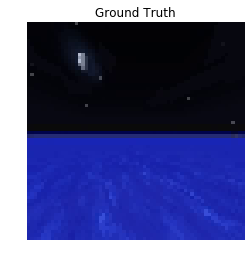

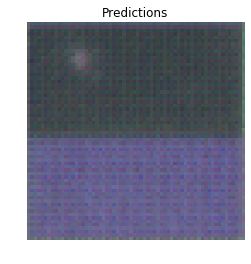

Loss:  tf.Tensor(0.6478127, shape=(), dtype=float32)
Epoch:  126


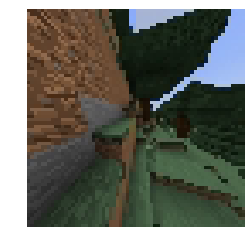

Data shape:  (64, 64, 3)


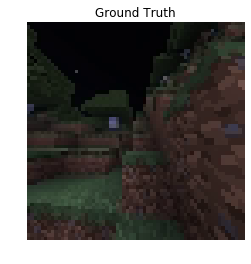

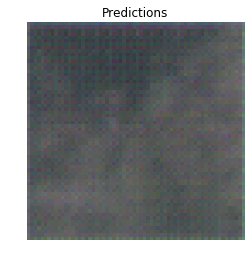

Loss:  tf.Tensor(0.6478164, shape=(), dtype=float32)
Epoch:  127


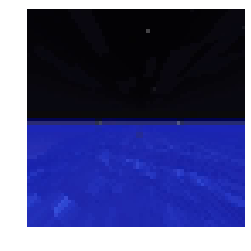

Data shape:  (64, 64, 3)


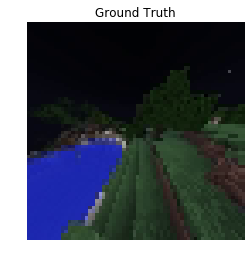

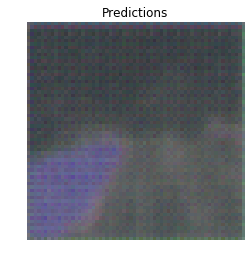

Loss:  tf.Tensor(0.6698895, shape=(), dtype=float32)
Epoch:  128


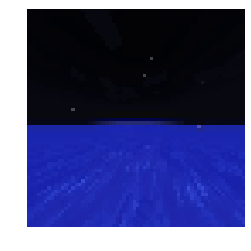

Data shape:  (64, 64, 3)


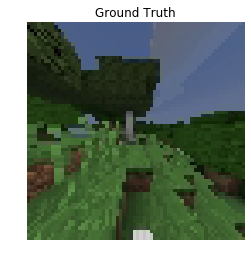

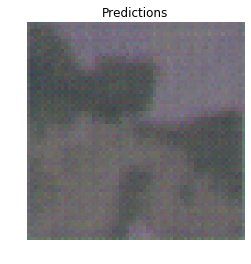

Loss:  tf.Tensor(0.64743376, shape=(), dtype=float32)
Epoch:  129


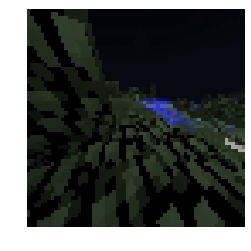

Data shape:  (64, 64, 3)


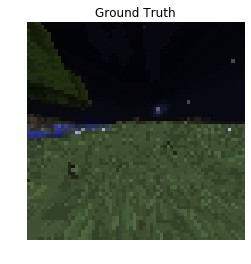

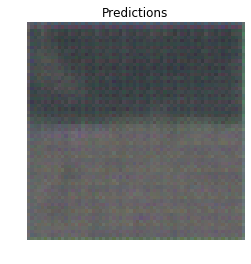

Loss:  tf.Tensor(0.66825134, shape=(), dtype=float32)
Epoch:  130


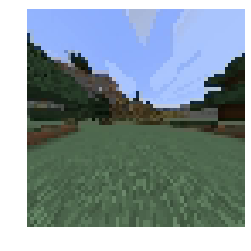

Data shape:  (64, 64, 3)


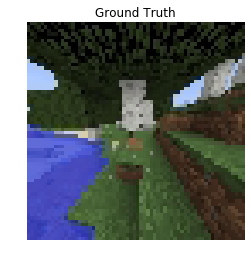

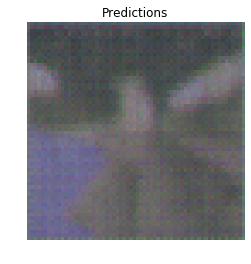

Loss:  tf.Tensor(0.6508423, shape=(), dtype=float32)
Epoch:  131


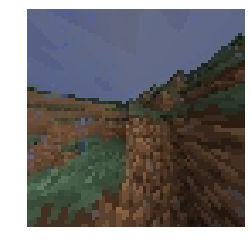

Data shape:  (64, 64, 3)


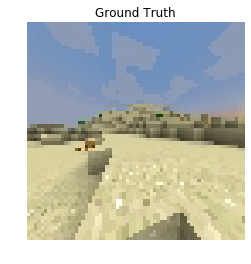

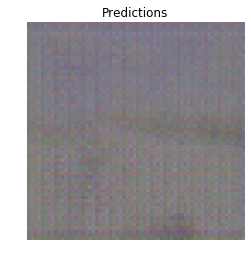

Loss:  tf.Tensor(0.686192, shape=(), dtype=float32)
Epoch:  132


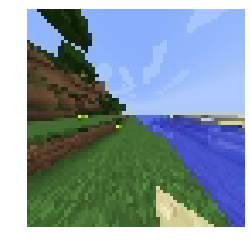

Data shape:  (64, 64, 3)


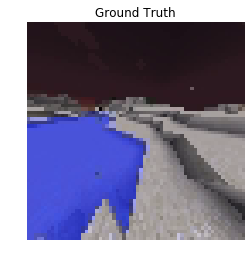

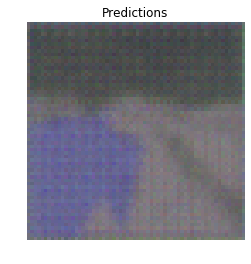

Loss:  tf.Tensor(0.6576193, shape=(), dtype=float32)
Epoch:  133


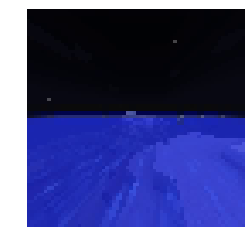

Data shape:  (64, 64, 3)


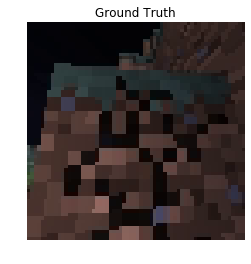

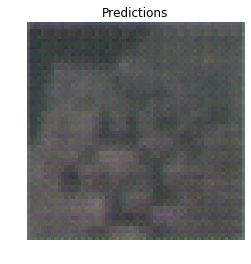

Loss:  tf.Tensor(0.63909805, shape=(), dtype=float32)
Epoch:  134


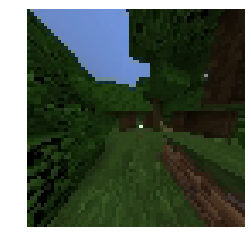

Data shape:  (64, 64, 3)


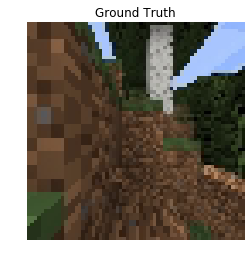

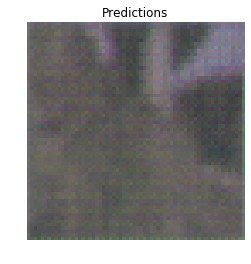

Loss:  tf.Tensor(0.6380985, shape=(), dtype=float32)
Epoch:  135


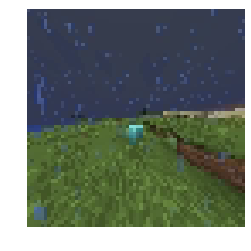

Data shape:  (64, 64, 3)


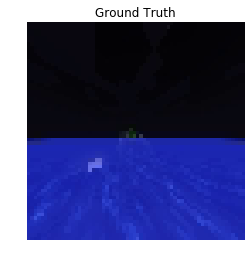

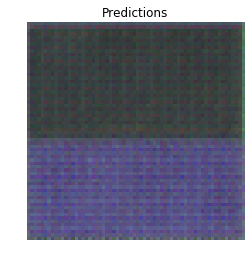

Loss:  tf.Tensor(0.64864165, shape=(), dtype=float32)
Epoch:  136


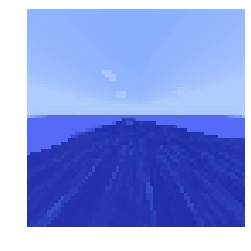

Data shape:  (64, 64, 3)


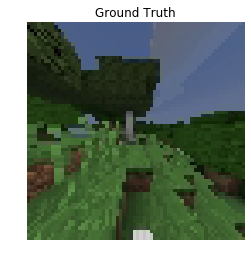

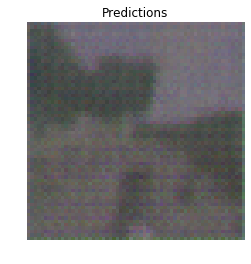

Loss:  tf.Tensor(0.64912724, shape=(), dtype=float32)
Epoch:  137


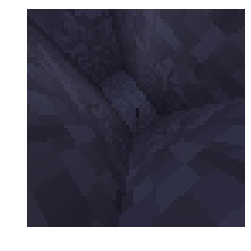

Data shape:  (64, 64, 3)


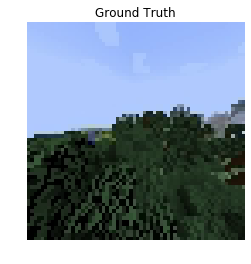

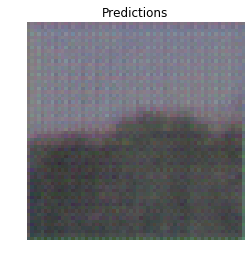

Loss:  tf.Tensor(0.66431504, shape=(), dtype=float32)
Epoch:  138


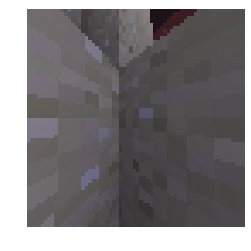

Data shape:  (64, 64, 3)


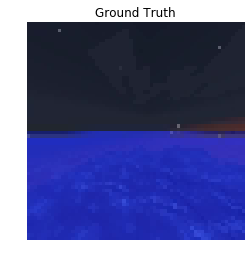

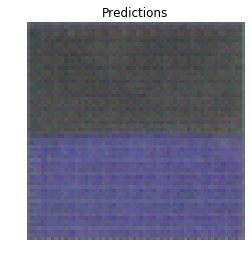

Loss:  tf.Tensor(0.65192175, shape=(), dtype=float32)
Epoch:  139


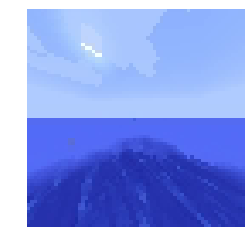

Data shape:  (64, 64, 3)


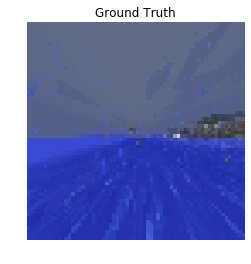

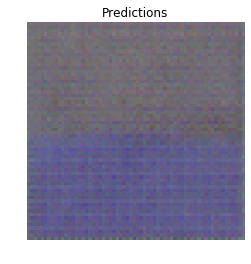

Loss:  tf.Tensor(0.6524912, shape=(), dtype=float32)
Epoch:  140


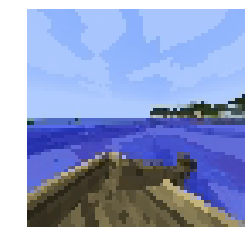

Data shape:  (64, 64, 3)


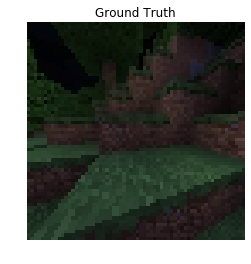

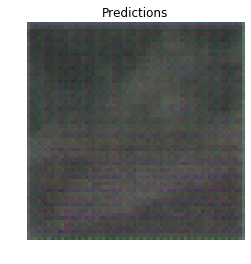

Loss:  tf.Tensor(0.6528982, shape=(), dtype=float32)
Epoch:  141


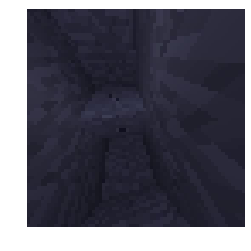

Data shape:  (64, 64, 3)


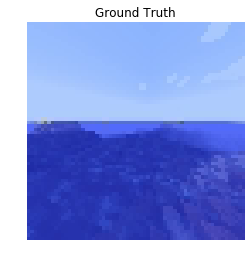

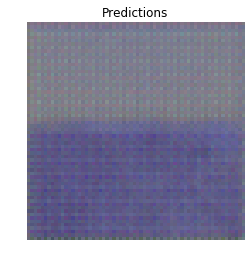

Loss:  tf.Tensor(0.6713169, shape=(), dtype=float32)
Epoch:  142


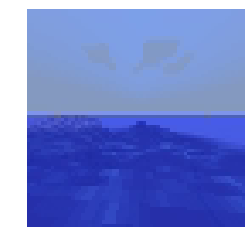

Data shape:  (64, 64, 3)


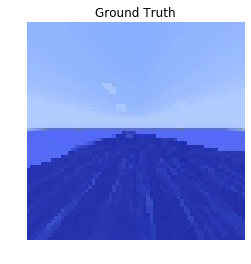

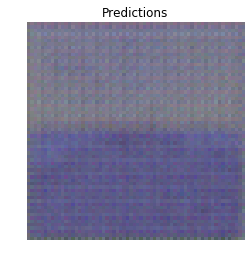

Loss:  tf.Tensor(0.662274, shape=(), dtype=float32)
Epoch:  143


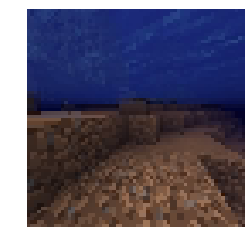

Data shape:  (64, 64, 3)


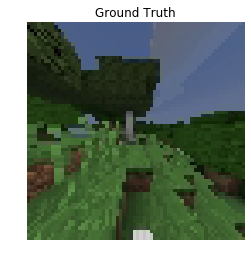

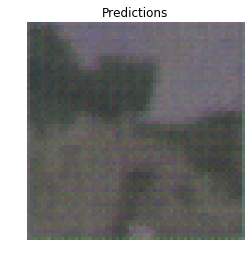

Loss:  tf.Tensor(0.64246184, shape=(), dtype=float32)
Epoch:  144


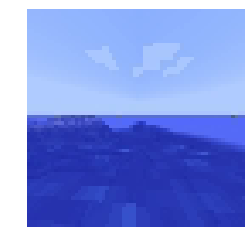

Data shape:  (64, 64, 3)


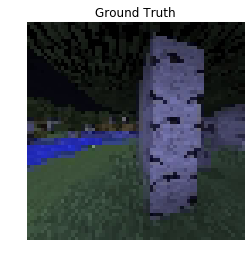

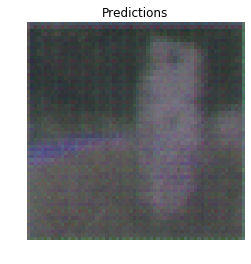

Loss:  tf.Tensor(0.66346055, shape=(), dtype=float32)
Epoch:  145


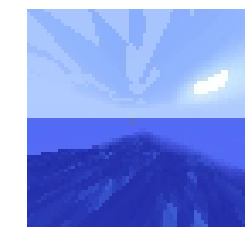

Data shape:  (64, 64, 3)


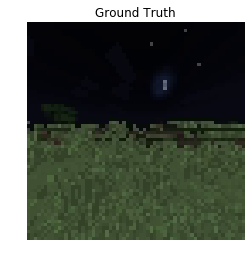

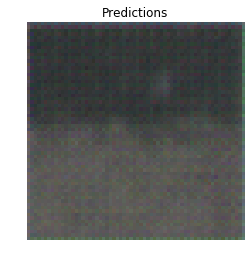

Loss:  tf.Tensor(0.6486909, shape=(), dtype=float32)
Epoch:  146


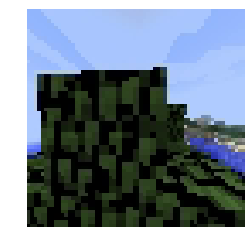

Data shape:  (64, 64, 3)


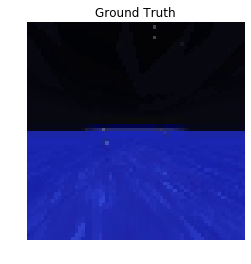

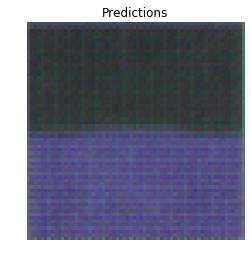

Loss:  tf.Tensor(0.6609944, shape=(), dtype=float32)
Epoch:  147


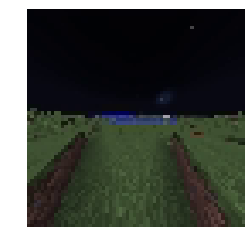

Data shape:  (64, 64, 3)


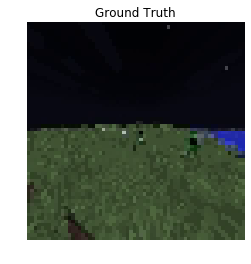

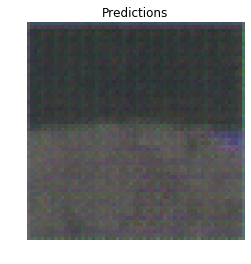

Loss:  tf.Tensor(0.65693176, shape=(), dtype=float32)
Epoch:  148


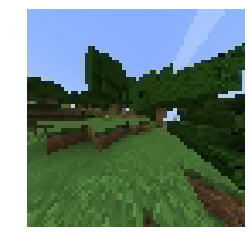

Data shape:  (64, 64, 3)


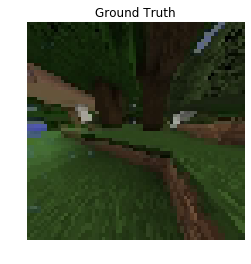

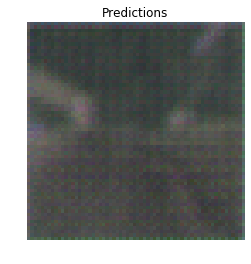

Loss:  tf.Tensor(0.69302887, shape=(), dtype=float32)
Epoch:  149


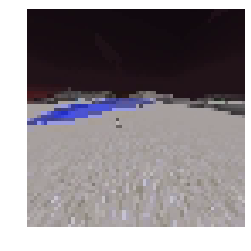

Data shape:  (64, 64, 3)


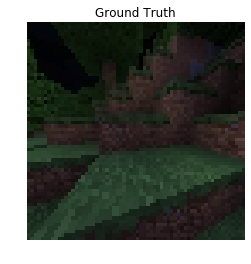

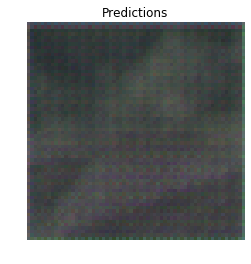

Loss:  tf.Tensor(0.6652173, shape=(), dtype=float32)
Epoch:  150


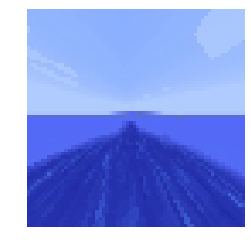

Data shape:  (64, 64, 3)


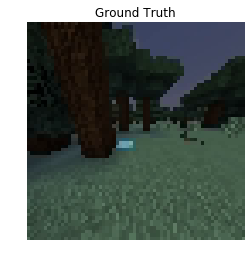

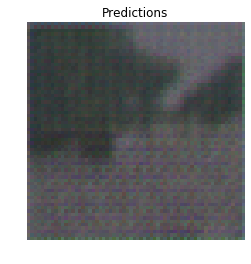

Loss:  tf.Tensor(0.6397013, shape=(), dtype=float32)
Epoch:  151


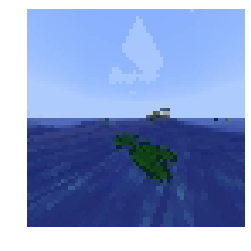

Data shape:  (64, 64, 3)


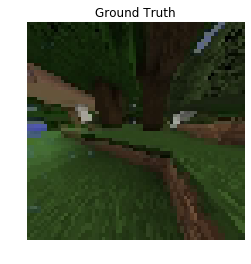

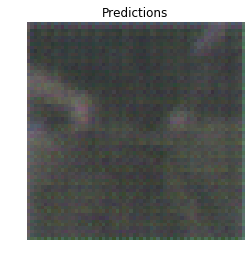

Loss:  tf.Tensor(0.6711893, shape=(), dtype=float32)
Epoch:  152


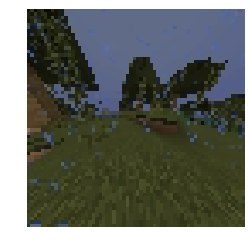

Data shape:  (64, 64, 3)


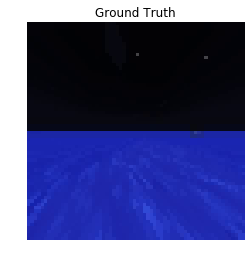

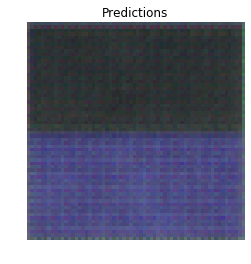

Loss:  tf.Tensor(0.66452724, shape=(), dtype=float32)
Epoch:  153


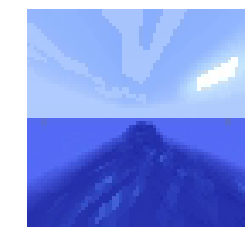

Data shape:  (64, 64, 3)


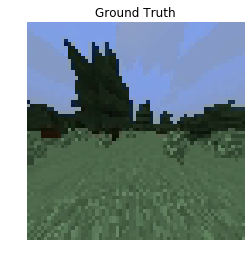

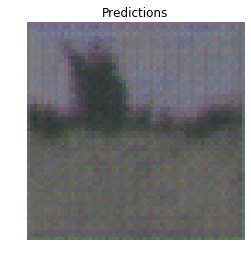

Loss:  tf.Tensor(0.66961825, shape=(), dtype=float32)
Epoch:  154


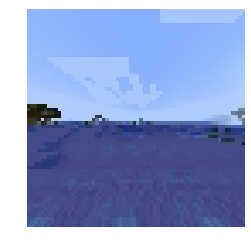

Data shape:  (64, 64, 3)


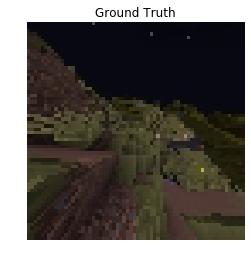

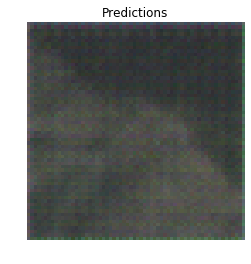

Loss:  tf.Tensor(0.64753073, shape=(), dtype=float32)
Epoch:  155


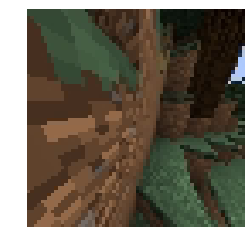

Data shape:  (64, 64, 3)


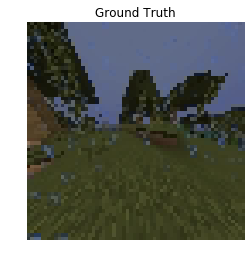

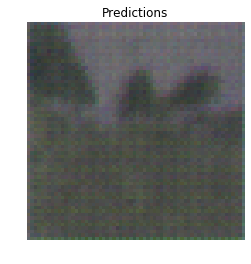

Loss:  tf.Tensor(0.6631837, shape=(), dtype=float32)
Epoch:  156


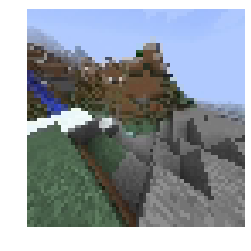

Data shape:  (64, 64, 3)


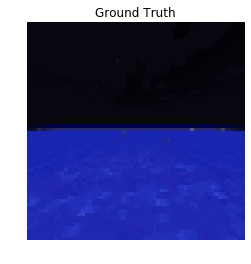

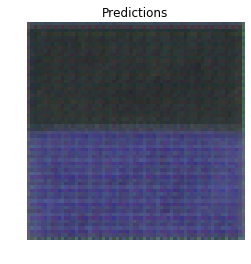

Loss:  tf.Tensor(0.6557089, shape=(), dtype=float32)
Epoch:  157


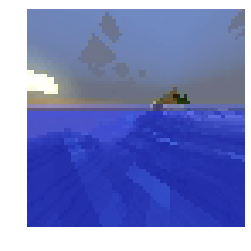

Data shape:  (64, 64, 3)


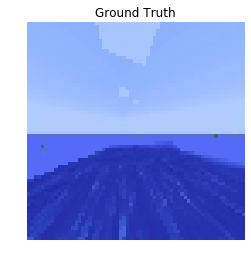

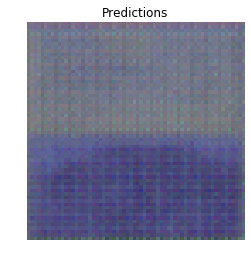

Loss:  tf.Tensor(0.64804864, shape=(), dtype=float32)
Epoch:  158


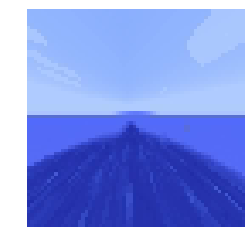

Data shape:  (64, 64, 3)


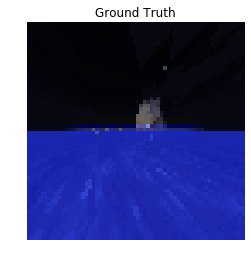

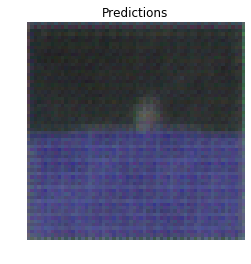

Loss:  tf.Tensor(0.714381, shape=(), dtype=float32)
Epoch:  159


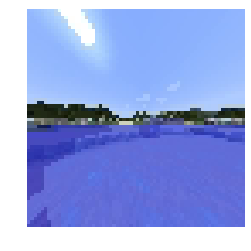

Data shape:  (64, 64, 3)


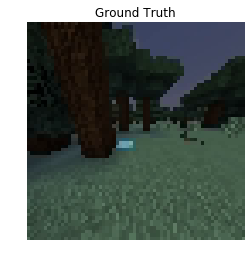

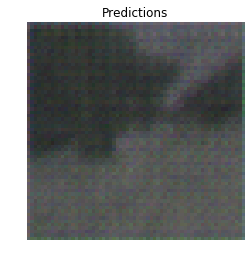

Loss:  tf.Tensor(0.65216535, shape=(), dtype=float32)
Epoch:  160


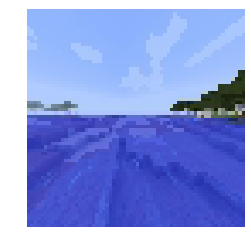

Data shape:  (64, 64, 3)


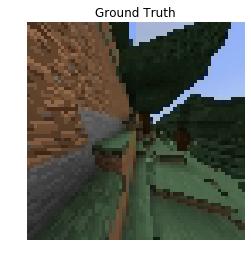

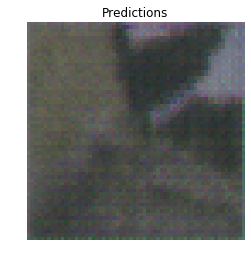

Loss:  tf.Tensor(0.66564745, shape=(), dtype=float32)
Epoch:  161


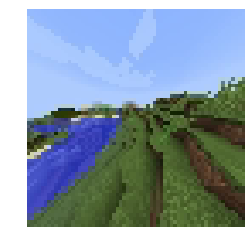

Data shape:  (64, 64, 3)


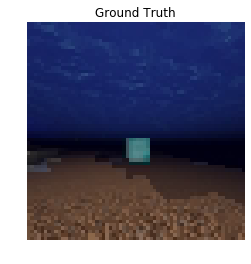

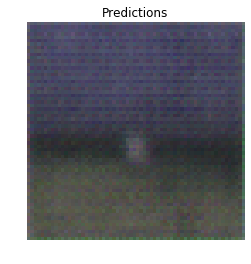

Loss:  tf.Tensor(0.68361795, shape=(), dtype=float32)
Epoch:  162


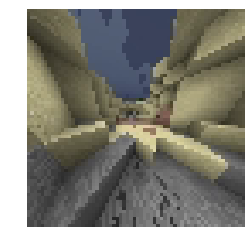

Data shape:  (64, 64, 3)


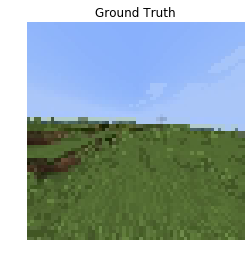

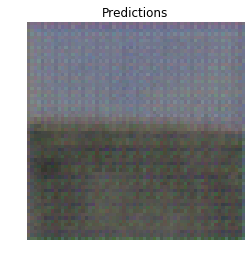

Loss:  tf.Tensor(0.66320544, shape=(), dtype=float32)
Epoch:  163


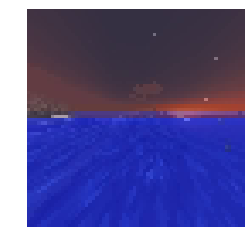

Data shape:  (64, 64, 3)


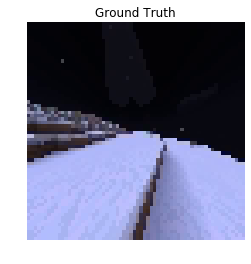

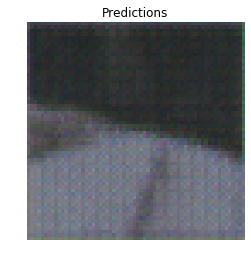

Loss:  tf.Tensor(0.7091181, shape=(), dtype=float32)
Epoch:  164


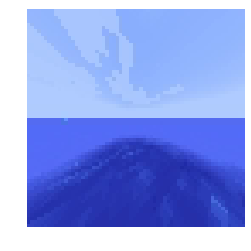

Data shape:  (64, 64, 3)


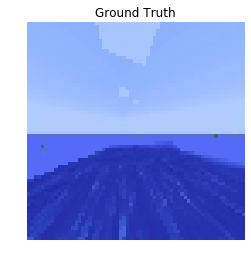

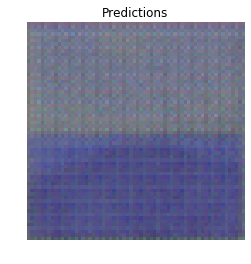

Loss:  tf.Tensor(0.65693617, shape=(), dtype=float32)
Epoch:  165


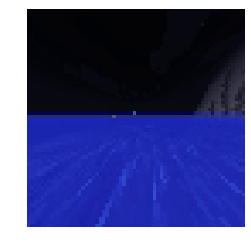

Data shape:  (64, 64, 3)


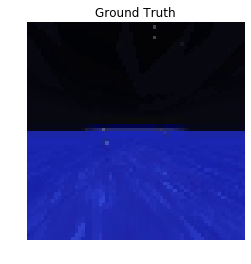

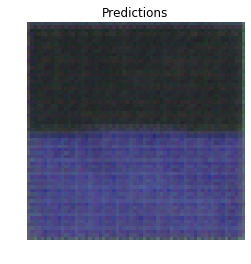

Loss:  tf.Tensor(0.6807818, shape=(), dtype=float32)
Epoch:  166


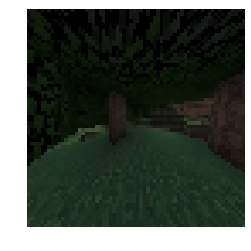

Data shape:  (64, 64, 3)


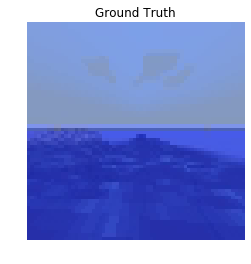

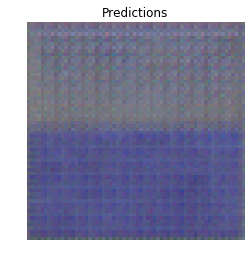

Loss:  tf.Tensor(0.65575033, shape=(), dtype=float32)
Epoch:  167


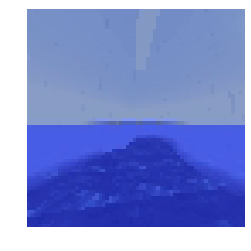

Data shape:  (64, 64, 3)


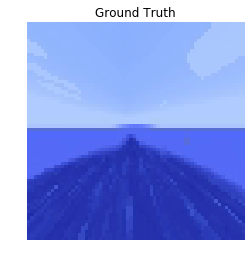

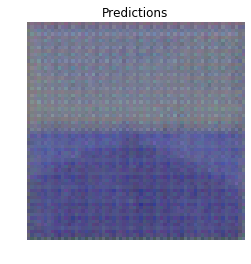

Loss:  tf.Tensor(0.66391987, shape=(), dtype=float32)
Epoch:  168


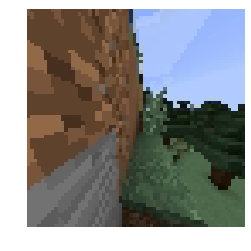

Data shape:  (64, 64, 3)


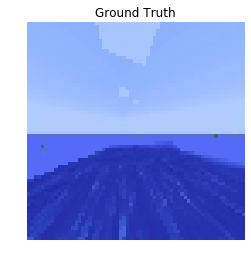

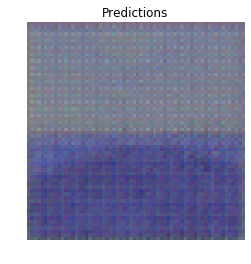

Loss:  tf.Tensor(0.668054, shape=(), dtype=float32)
Epoch:  169


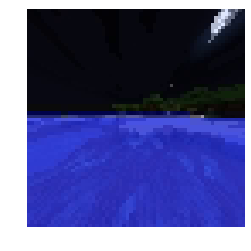

Data shape:  (64, 64, 3)


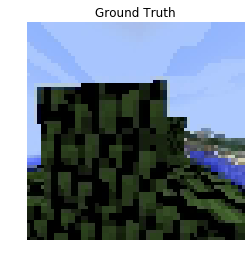

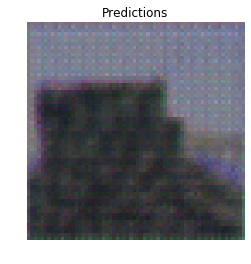

Loss:  tf.Tensor(0.6880272, shape=(), dtype=float32)
Epoch:  170


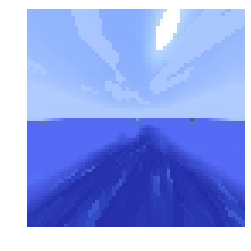

Data shape:  (64, 64, 3)


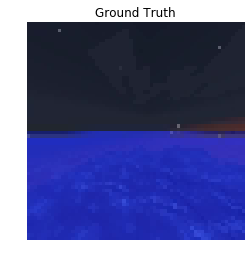

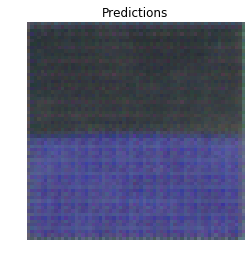

Loss:  tf.Tensor(0.6750769, shape=(), dtype=float32)
Epoch:  171


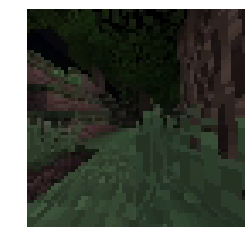

Data shape:  (64, 64, 3)


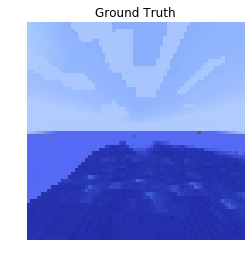

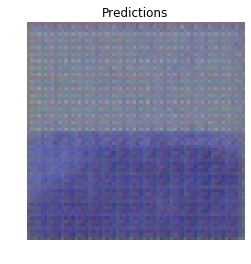

Loss:  tf.Tensor(0.6683453, shape=(), dtype=float32)
Epoch:  172


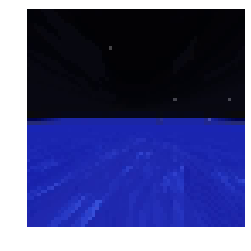

Data shape:  (64, 64, 3)


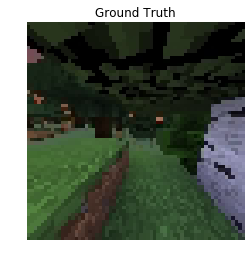

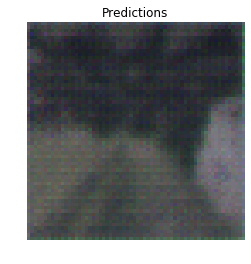

Loss:  tf.Tensor(0.70664537, shape=(), dtype=float32)
Epoch:  173


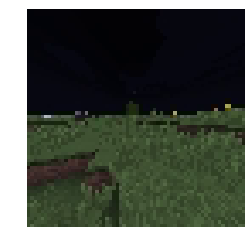

Data shape:  (64, 64, 3)


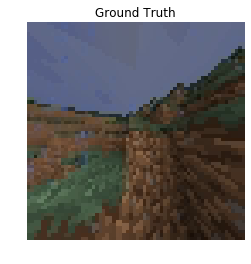

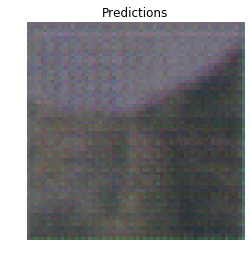

Loss:  tf.Tensor(0.669785, shape=(), dtype=float32)
Epoch:  174


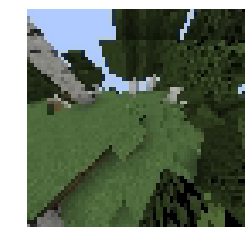

Data shape:  (64, 64, 3)


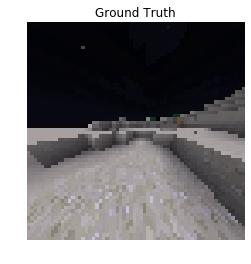

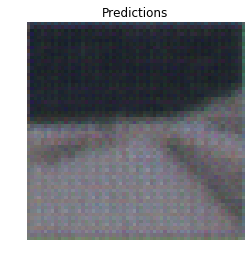

Loss:  tf.Tensor(0.69352674, shape=(), dtype=float32)
Epoch:  175


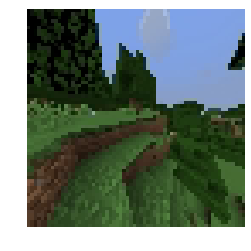

Data shape:  (64, 64, 3)


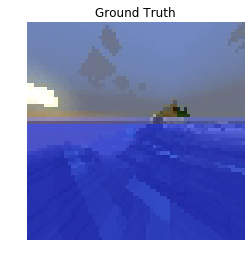

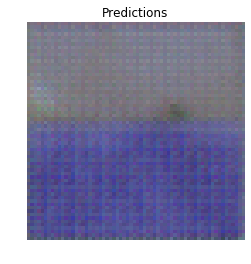

Loss:  tf.Tensor(0.6585229, shape=(), dtype=float32)
Epoch:  176


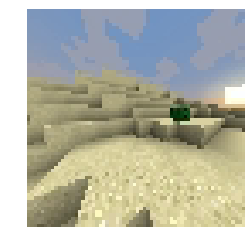

Data shape:  (64, 64, 3)


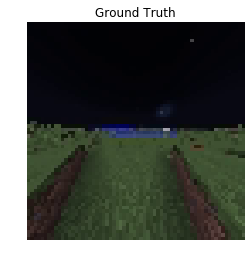

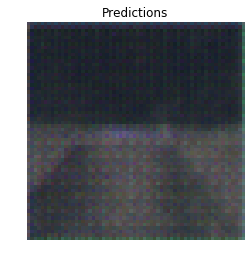

Loss:  tf.Tensor(0.6890387, shape=(), dtype=float32)
Epoch:  177


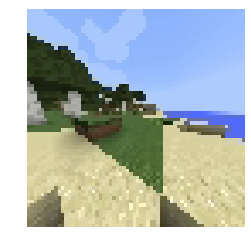

Data shape:  (64, 64, 3)


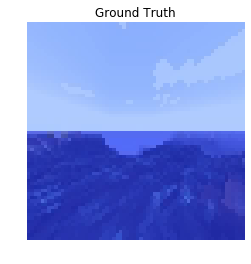

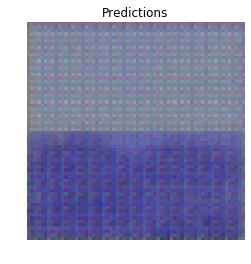

Loss:  tf.Tensor(0.67705715, shape=(), dtype=float32)
Epoch:  178


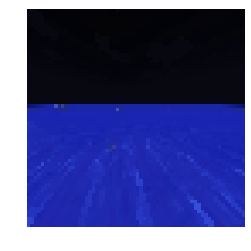

Data shape:  (64, 64, 3)


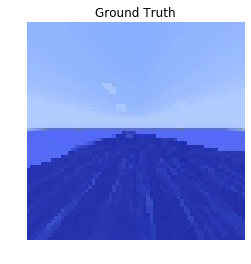

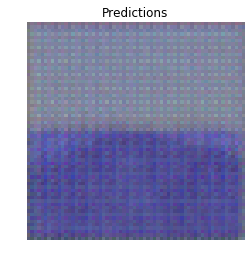

Loss:  tf.Tensor(0.6810347, shape=(), dtype=float32)
Epoch:  179


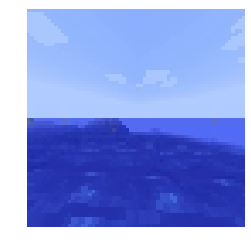

Data shape:  (64, 64, 3)


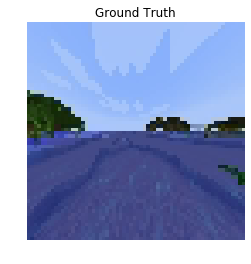

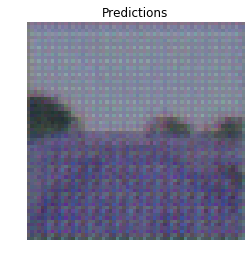

Loss:  tf.Tensor(0.6679261, shape=(), dtype=float32)
Epoch:  180


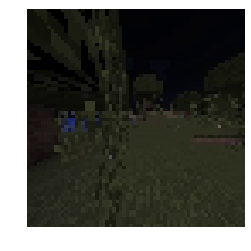

Data shape:  (64, 64, 3)


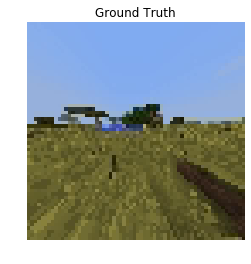

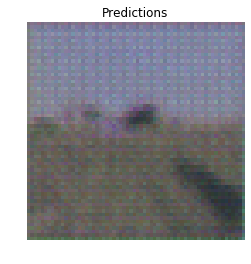

Loss:  tf.Tensor(0.67484105, shape=(), dtype=float32)
Epoch:  181


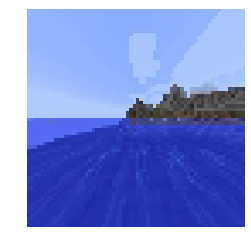

Data shape:  (64, 64, 3)


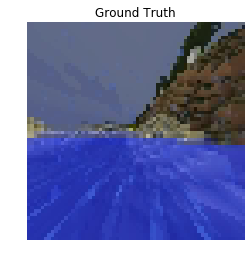

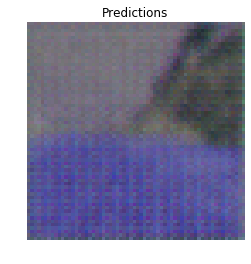

Loss:  tf.Tensor(0.66247344, shape=(), dtype=float32)
Epoch:  182


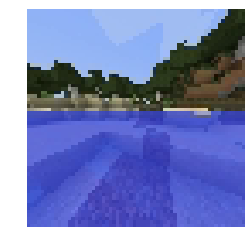

Data shape:  (64, 64, 3)


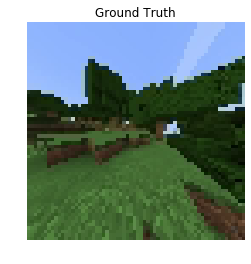

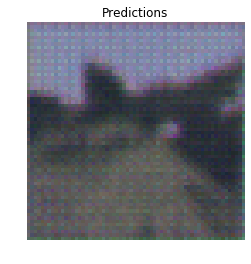

Loss:  tf.Tensor(0.6990765, shape=(), dtype=float32)
Epoch:  183


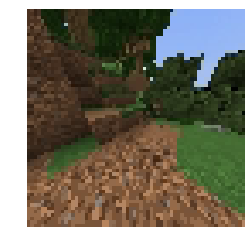

Data shape:  (64, 64, 3)


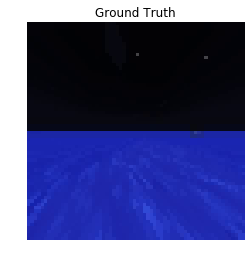

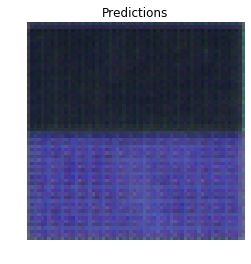

Loss:  tf.Tensor(0.75631094, shape=(), dtype=float32)
Epoch:  184


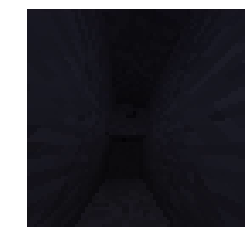

Data shape:  (64, 64, 3)


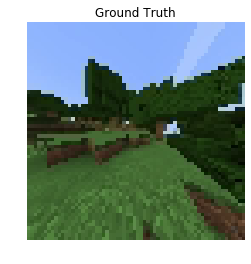

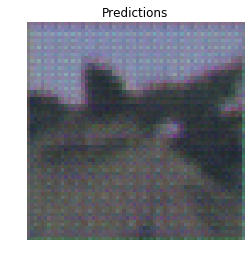

Loss:  tf.Tensor(0.6850512, shape=(), dtype=float32)
Epoch:  185


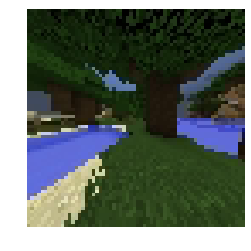

Data shape:  (64, 64, 3)


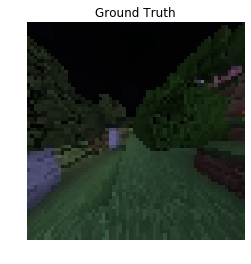

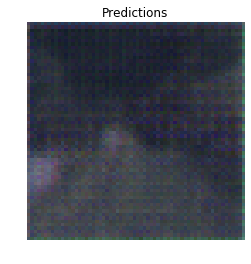

Loss:  tf.Tensor(0.716259, shape=(), dtype=float32)
Epoch:  186


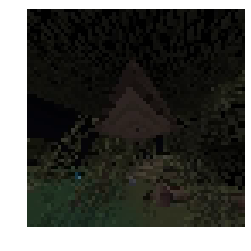

Data shape:  (64, 64, 3)


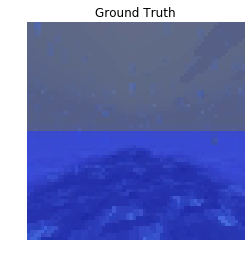

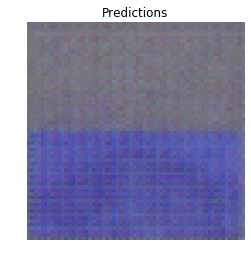

Loss:  tf.Tensor(0.6641334, shape=(), dtype=float32)
Epoch:  187


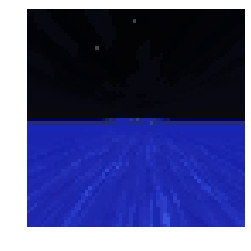

Data shape:  (64, 64, 3)


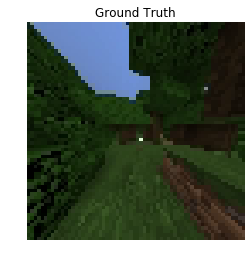

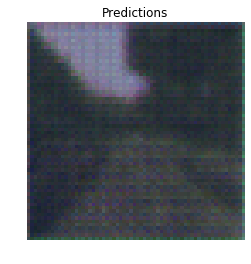

Loss:  tf.Tensor(0.69262385, shape=(), dtype=float32)
Epoch:  188


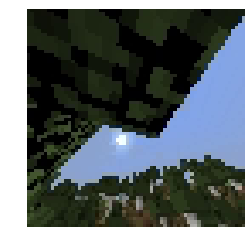

Data shape:  (64, 64, 3)


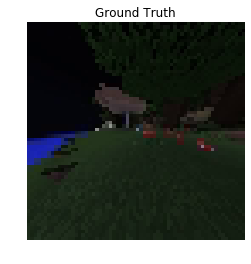

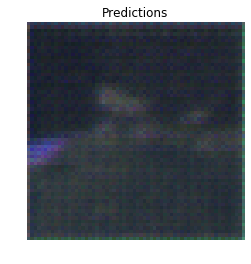

Loss:  tf.Tensor(0.7701847, shape=(), dtype=float32)
Epoch:  189


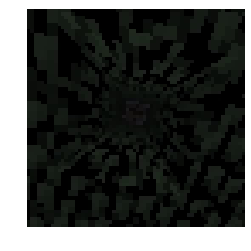

Data shape:  (64, 64, 3)


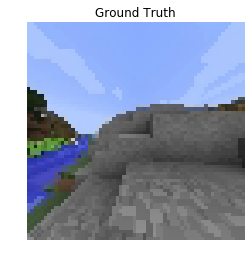

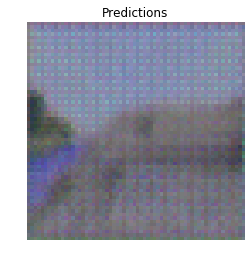

Loss:  tf.Tensor(0.6939139, shape=(), dtype=float32)
Epoch:  190


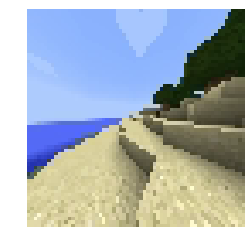

Data shape:  (64, 64, 3)


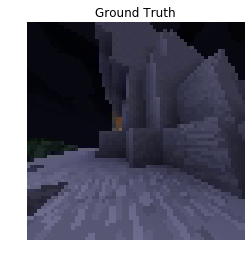

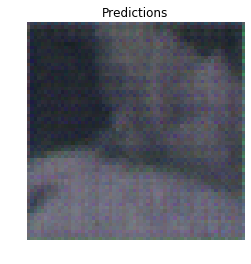

Loss:  tf.Tensor(0.6572939, shape=(), dtype=float32)
Epoch:  191


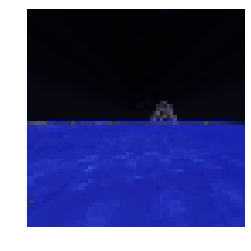

Data shape:  (64, 64, 3)


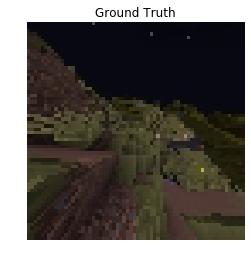

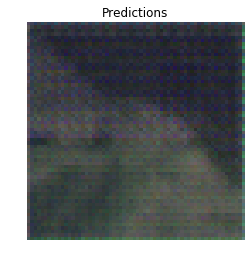

Loss:  tf.Tensor(0.6885278, shape=(), dtype=float32)
Epoch:  192


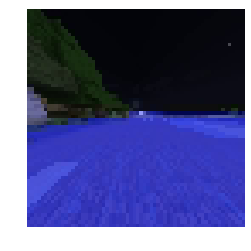

Data shape:  (64, 64, 3)


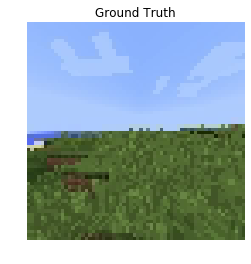

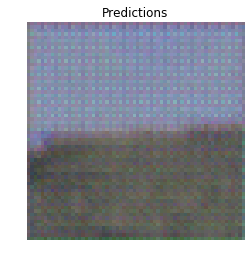

Loss:  tf.Tensor(0.69837934, shape=(), dtype=float32)
Epoch:  193


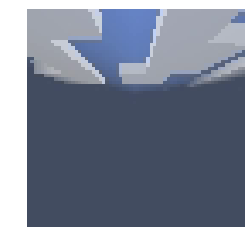

Data shape:  (64, 64, 3)


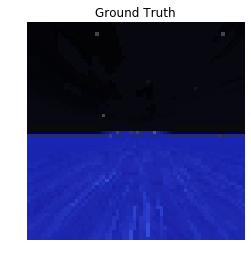

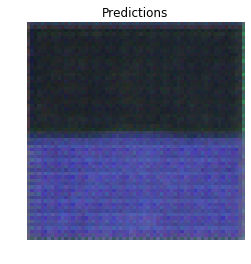

Loss:  tf.Tensor(0.7140392, shape=(), dtype=float32)
Epoch:  194


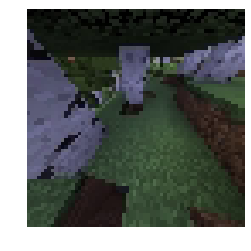

Data shape:  (64, 64, 3)


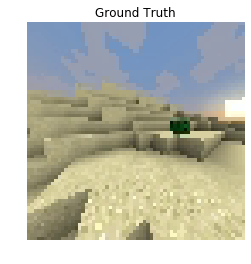

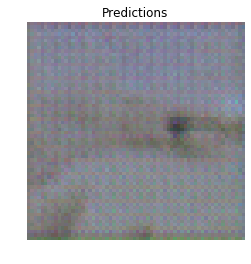

Loss:  tf.Tensor(0.7093235, shape=(), dtype=float32)
Epoch:  195


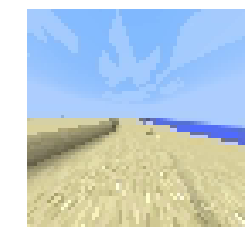

Data shape:  (64, 64, 3)


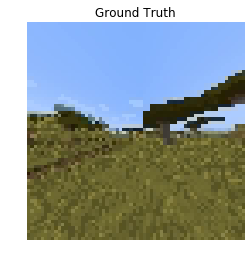

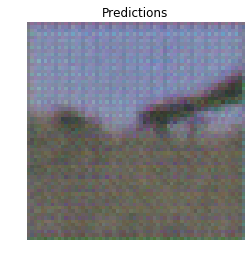

Loss:  tf.Tensor(0.69135976, shape=(), dtype=float32)
Epoch:  196


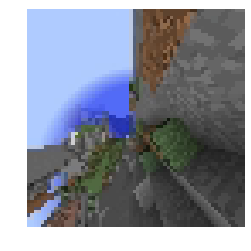

Data shape:  (64, 64, 3)


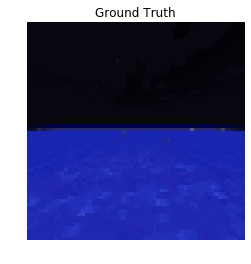

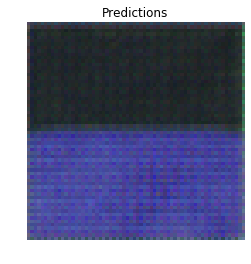

Loss:  tf.Tensor(0.7136028, shape=(), dtype=float32)
Epoch:  197


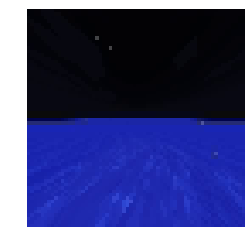

Data shape:  (64, 64, 3)


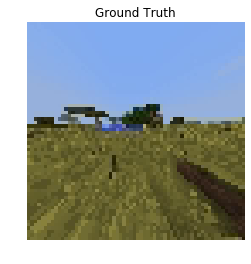

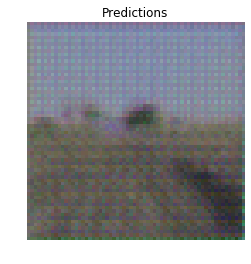

Loss:  tf.Tensor(0.68747723, shape=(), dtype=float32)
Epoch:  198


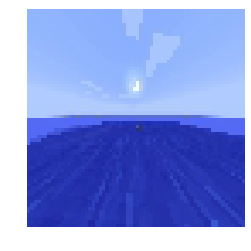

Data shape:  (64, 64, 3)


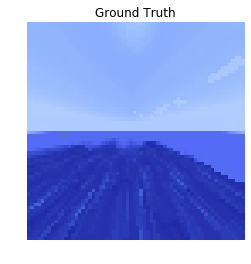

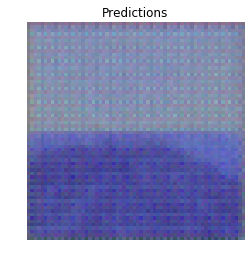

Loss:  tf.Tensor(0.6943506, shape=(), dtype=float32)
Epoch:  199


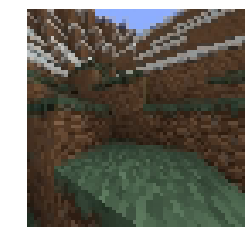

Data shape:  (64, 64, 3)


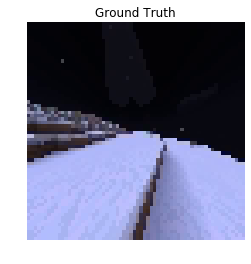

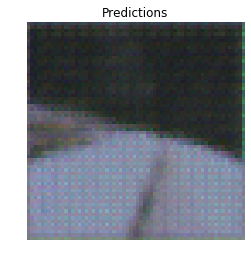

Loss:  tf.Tensor(0.72355014, shape=(), dtype=float32)
Epoch:  200


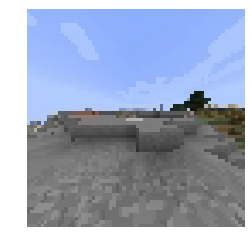

Data shape:  (64, 64, 3)


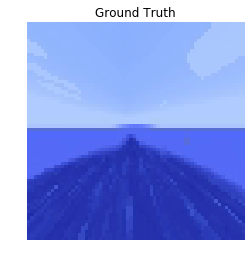

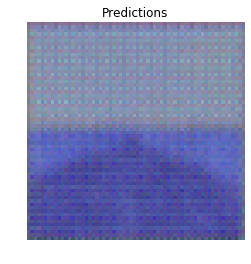

Loss:  tf.Tensor(0.6971952, shape=(), dtype=float32)


In [140]:
optimizer = keras.optimizers.Adam(lr=0.001)
autoencoder.compile(loss="binary_crossentropy", optimizer=optimizer)

replay_buffer = deque(maxlen=5000)

def train_vae():
    blur_decrease = 0
    batch_size = 128
    
    for epoch in range(200):
        print("Epoch: ", epoch + 1)
        
        state = load_data(blur_pixel=64)
        replay_buffer.append(state)

        if epoch >= 10:
            
            if blur_decrease != 10:
                blur_decrease += 0.1
            indices = np.random.randint(len(replay_buffer), size=batch_size)
            batch = [replay_buffer[index] for index in indices]
            
            autoencoder.train_on_batch(batch, batch)

            predictions = autoencoder(batch)
            plt.imshow(batch[0][0])
            plt.title("Ground Truth")
            plt.axis("off")
            plt.show()
            
            plt.imshow(predictions.numpy()[0])
            plt.title("Predictions")
            plt.axis("off")
            plt.show()
            
            loss = keras.losses.BinaryCrossentropy(from_logits=False)(batch, predictions)
            print("Loss: ", loss)

train_vae()

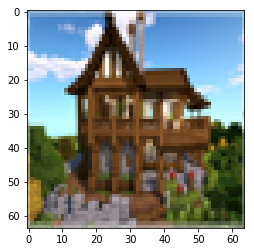

(1, 64, 64, 3)


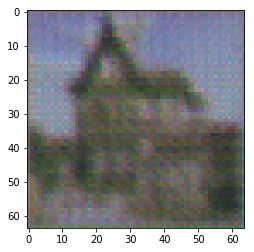

In [141]:
test_data = np.array(Image.open("unseen_minecraft_test_image.jpg").resize((64, 64)))[np.newaxis].astype(np.uint8)
test_data = test_data / 255.

plt.imshow(test_data[0])
plt.show()

image = autoencoder(test_data)
print(image.shape)

plt.imshow(np.array(image[0]*255).astype(np.uint8))
plt.show()

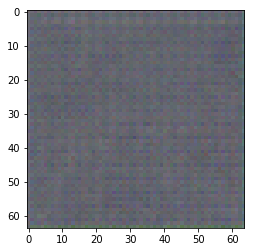

In [153]:
test_codings = tf.random.normal(shape=(1, 500))
test_preprocessing = tf.zeros(shape=(1, 32, 32, 32))

image = decoder([test_codings, test_preprocessing]).numpy()
image = np.squeeze(image)

plt.imshow(image)
plt.show()